In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd

In [5]:
!pwd

/Users/raj/Documents/site/polar-vortex/_python


In [15]:
df_traj_0 = pd.read_csv('_output/_traj/jetstream_traj_2001-01-01.csv')
df_traj_1 = pd.read_csv('_output/_traj/jetstream_traj_2001-01-01_aligned.csv')

df_traj_0.head()
df_traj_1.head()

,longitude,latitude
0,-179.900000,41.563228
1,-179.611931,41.415685
2,-179.327076,41.267470
3,-179.045232,41.118503
4,-178.766345,40.968717


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


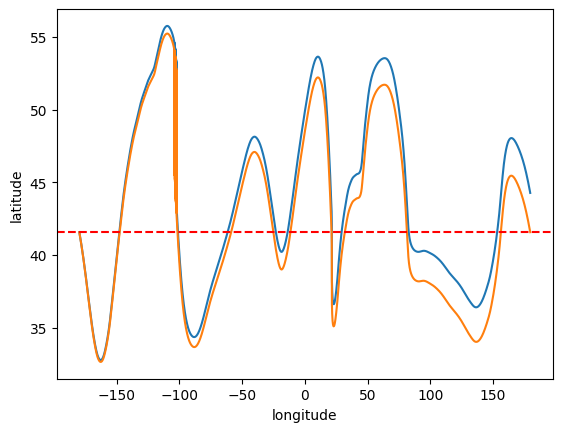

In [20]:
sns.lineplot(x='longitude', y='latitude', data=df_traj_0)
sns.lineplot(x='longitude', y='latitude', data=df_traj_1)
# Get y-value of first point
start_lat = df_traj_0.iloc[0]['latitude']
# Add horizontal line at that latitude
plt.axhline(y=start_lat, color='r', linestyle='--')
# plt.xlim(-120, -90)
plt.show()

In [63]:
df_dlat = pd.read_csv("_output/yearly_max_latitude_range.csv")

In [64]:
# list(df_dlat['filename'])

In [62]:
import os
from pathlib import Path

traj_dir = Path("_output/_traj")
for file in traj_dir.glob("jetstream_traj_*.csv"):
    new_name = file.stem.split("T")[0] + ".csv"
    file.rename(file.parent / new_name)

In [65]:
df_dlat['year'] = pd.to_datetime(df_dlat['date']).dt.year


In [66]:
df_dlat.sample(2)

,year,date,filename,lat_diff,max_lat,min_lat
17,2017,2017-01-06,jetstream_traj_2017-01-06T00:00:00.000000000.csv,32.139648,68.827313,36.687665
0,2000,2000-01-21,jetstream_traj_2000-01-21T00:00:00.000000000.csv,28.997488,65.134552,36.137064


In [81]:
list(df_dlat.filename)

['jetstream_traj_2000-01-21T00:00:00.000000000.csv',
 'jetstream_traj_2001-01-08T00:00:00.000000000.csv',
 'jetstream_traj_2002-01-01T00:00:00.000000000.csv',
 'jetstream_traj_2003-02-07T00:00:00.000000000.csv',
 'jetstream_traj_2004-02-11T00:00:00.000000000.csv',
 'jetstream_traj_2005-01-04T00:00:00.000000000.csv',
 'jetstream_traj_2006-02-16T00:00:00.000000000.csv',
 'jetstream_traj_2007-02-01T00:00:00.000000000.csv',
 'jetstream_traj_2008-01-20T00:00:00.000000000.csv',
 'jetstream_traj_2009-01-19T00:00:00.000000000.csv',
 'jetstream_traj_2010-02-04T00:00:00.000000000.csv',
 'jetstream_traj_2011-02-01T00:00:00.000000000.csv',
 'jetstream_traj_2012-02-09T00:00:00.000000000.csv',
 'jetstream_traj_2013-01-14T00:00:00.000000000.csv',
 'jetstream_traj_2014-01-30T00:00:00.000000000.csv',
 'jetstream_traj_2015-01-08T00:00:00.000000000.csv',
 'jetstream_traj_2016-02-09T00:00:00.000000000.csv',
 'jetstream_traj_2017-01-06T00:00:00.000000000.csv',
 'jetstream_traj_2018-01-15T00:00:00.000000000

In [197]:
df = pd.read_csv("_output/analysis_vortex_2000_2024_500mb.csv")

In [261]:
df.columns

Index(['date', 'displacement', 'stretching', 'mean_gradient',
       'gradient_uniformity', 'n_maxima', 'primary_maximum_dist',
       'polar_height', 'aspect_ratio', 'ellipticity', 'moment_ratio',
       'asymmetry', 'pca_ratio', 'pca_explained', 'elongation_index',
       'edge_displacement', 'winter_season', 'winter_season_short'],
      dtype='object')

In [215]:
def plot_metrics(df_input):

    df = df_input.copy()

    df["date"] = pd.to_datetime(df["date"])

    # drop all rows where the month is not january, february, or december
    df = df[df["date"].dt.month.isin([1, 2, 12])]

    df["winter_season"] = df["date"].apply(
        lambda x: (
            f"{x.year-1}-{x.year}"
            if x.month in [1, 2]
            else f"{x.year}-{x.year+1}" if x.month == 12 else None
        )
    )
    df["winter_season_short"] = df["winter_season"].apply(
        lambda x: f"{x.split('-')[0][-2:]}-{x.split('-')[1][-2:]}"
    )

    winter_stats_df = df.groupby("winter_season_short").agg(
        {
            "displacement": ["max", "min", "mean", "std"],
            "stretching": ["max", "min", "mean", "std"],
            "mean_gradient": ["max", "min", "mean", "std"],
            "gradient_uniformity": ["max", "min", "mean", "std"],
            "n_maxima": ["max", "min", "mean", "std"],
            "primary_maximum_dist": ["max", "min", "mean", "std"],
            "polar_height": ["max", "min", "mean", "std"],
            "aspect_ratio": ["max", "min", "mean", "std"],
            "ellipticity": ["max", "min", "mean", "std"],
            "moment_ratio": ["max", "min", "mean", "std"],
            "asymmetry": ["max", "min", "mean", "std"],
            "pca_ratio": ["max", "min", "mean", "std"],
            "pca_explained": ["max", "min", "mean", "std"],
            "elongation_index": ["max", "min", "mean", "std"],
            "edge_displacement": ["max", "min", "mean", "std"],
        }
    )

    # drop the row where the winter_season_short is 99-00
    winter_stats_df = winter_stats_df[winter_stats_df.index != "99-00"]
    winter_stats_df = winter_stats_df[winter_stats_df.index != "24-25"]

    metrics = [
        "displacement",
        "stretching",
        "mean_gradient",
        "gradient_uniformity",
        "n_maxima",
        "primary_maximum_dist",
        "polar_height",
        "aspect_ratio",
        "ellipticity",
        "moment_ratio",
        "asymmetry",
        "pca_ratio",
        "pca_explained",
        "elongation_index",
        "edge_displacement",
    ]

    # Create a figure with subplots for each metric
    fig, axes = plt.subplots(5, 3, figsize=(15, 25))
    axes = axes.ravel()

    # Plot max values for each metric
    for i, metric in enumerate(metrics):
        # Get x and y values
        x = np.arange(len(winter_stats_df.index))
        y = winter_stats_df[(metric, "mean")].values
        yerr = winter_stats_df[(metric, "std")].values

        # Plot points with error bars
        for j, season in enumerate(winter_stats_df.index):
            if season in ["13-14", "20-21"]:
                axes[i].errorbar(
                    j, y[j], yerr=yerr[j], fmt="o", capsize=3, color="black", lw=2
                )
            else:
                axes[i].errorbar(
                    j, y[j], yerr=yerr[j], fmt="o", capsize=3, color="gray", lw=1
                )

        # Add trend line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        axes[i].plot(x, p(x), "r--", alpha=0.8)

        # Customize plot
        axes[i].set_title(f"Mean {metric}")
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(winter_stats_df.index, rotation=90)

    plt.tight_layout()
    plt.show()

In [211]:
df_500mb = pd.read_csv("_output/analysis_vortex_2000_2024_500mb.csv")
df_100mb = pd.read_csv("_output/analysis_vortex_2000_2024_100mb.csv")


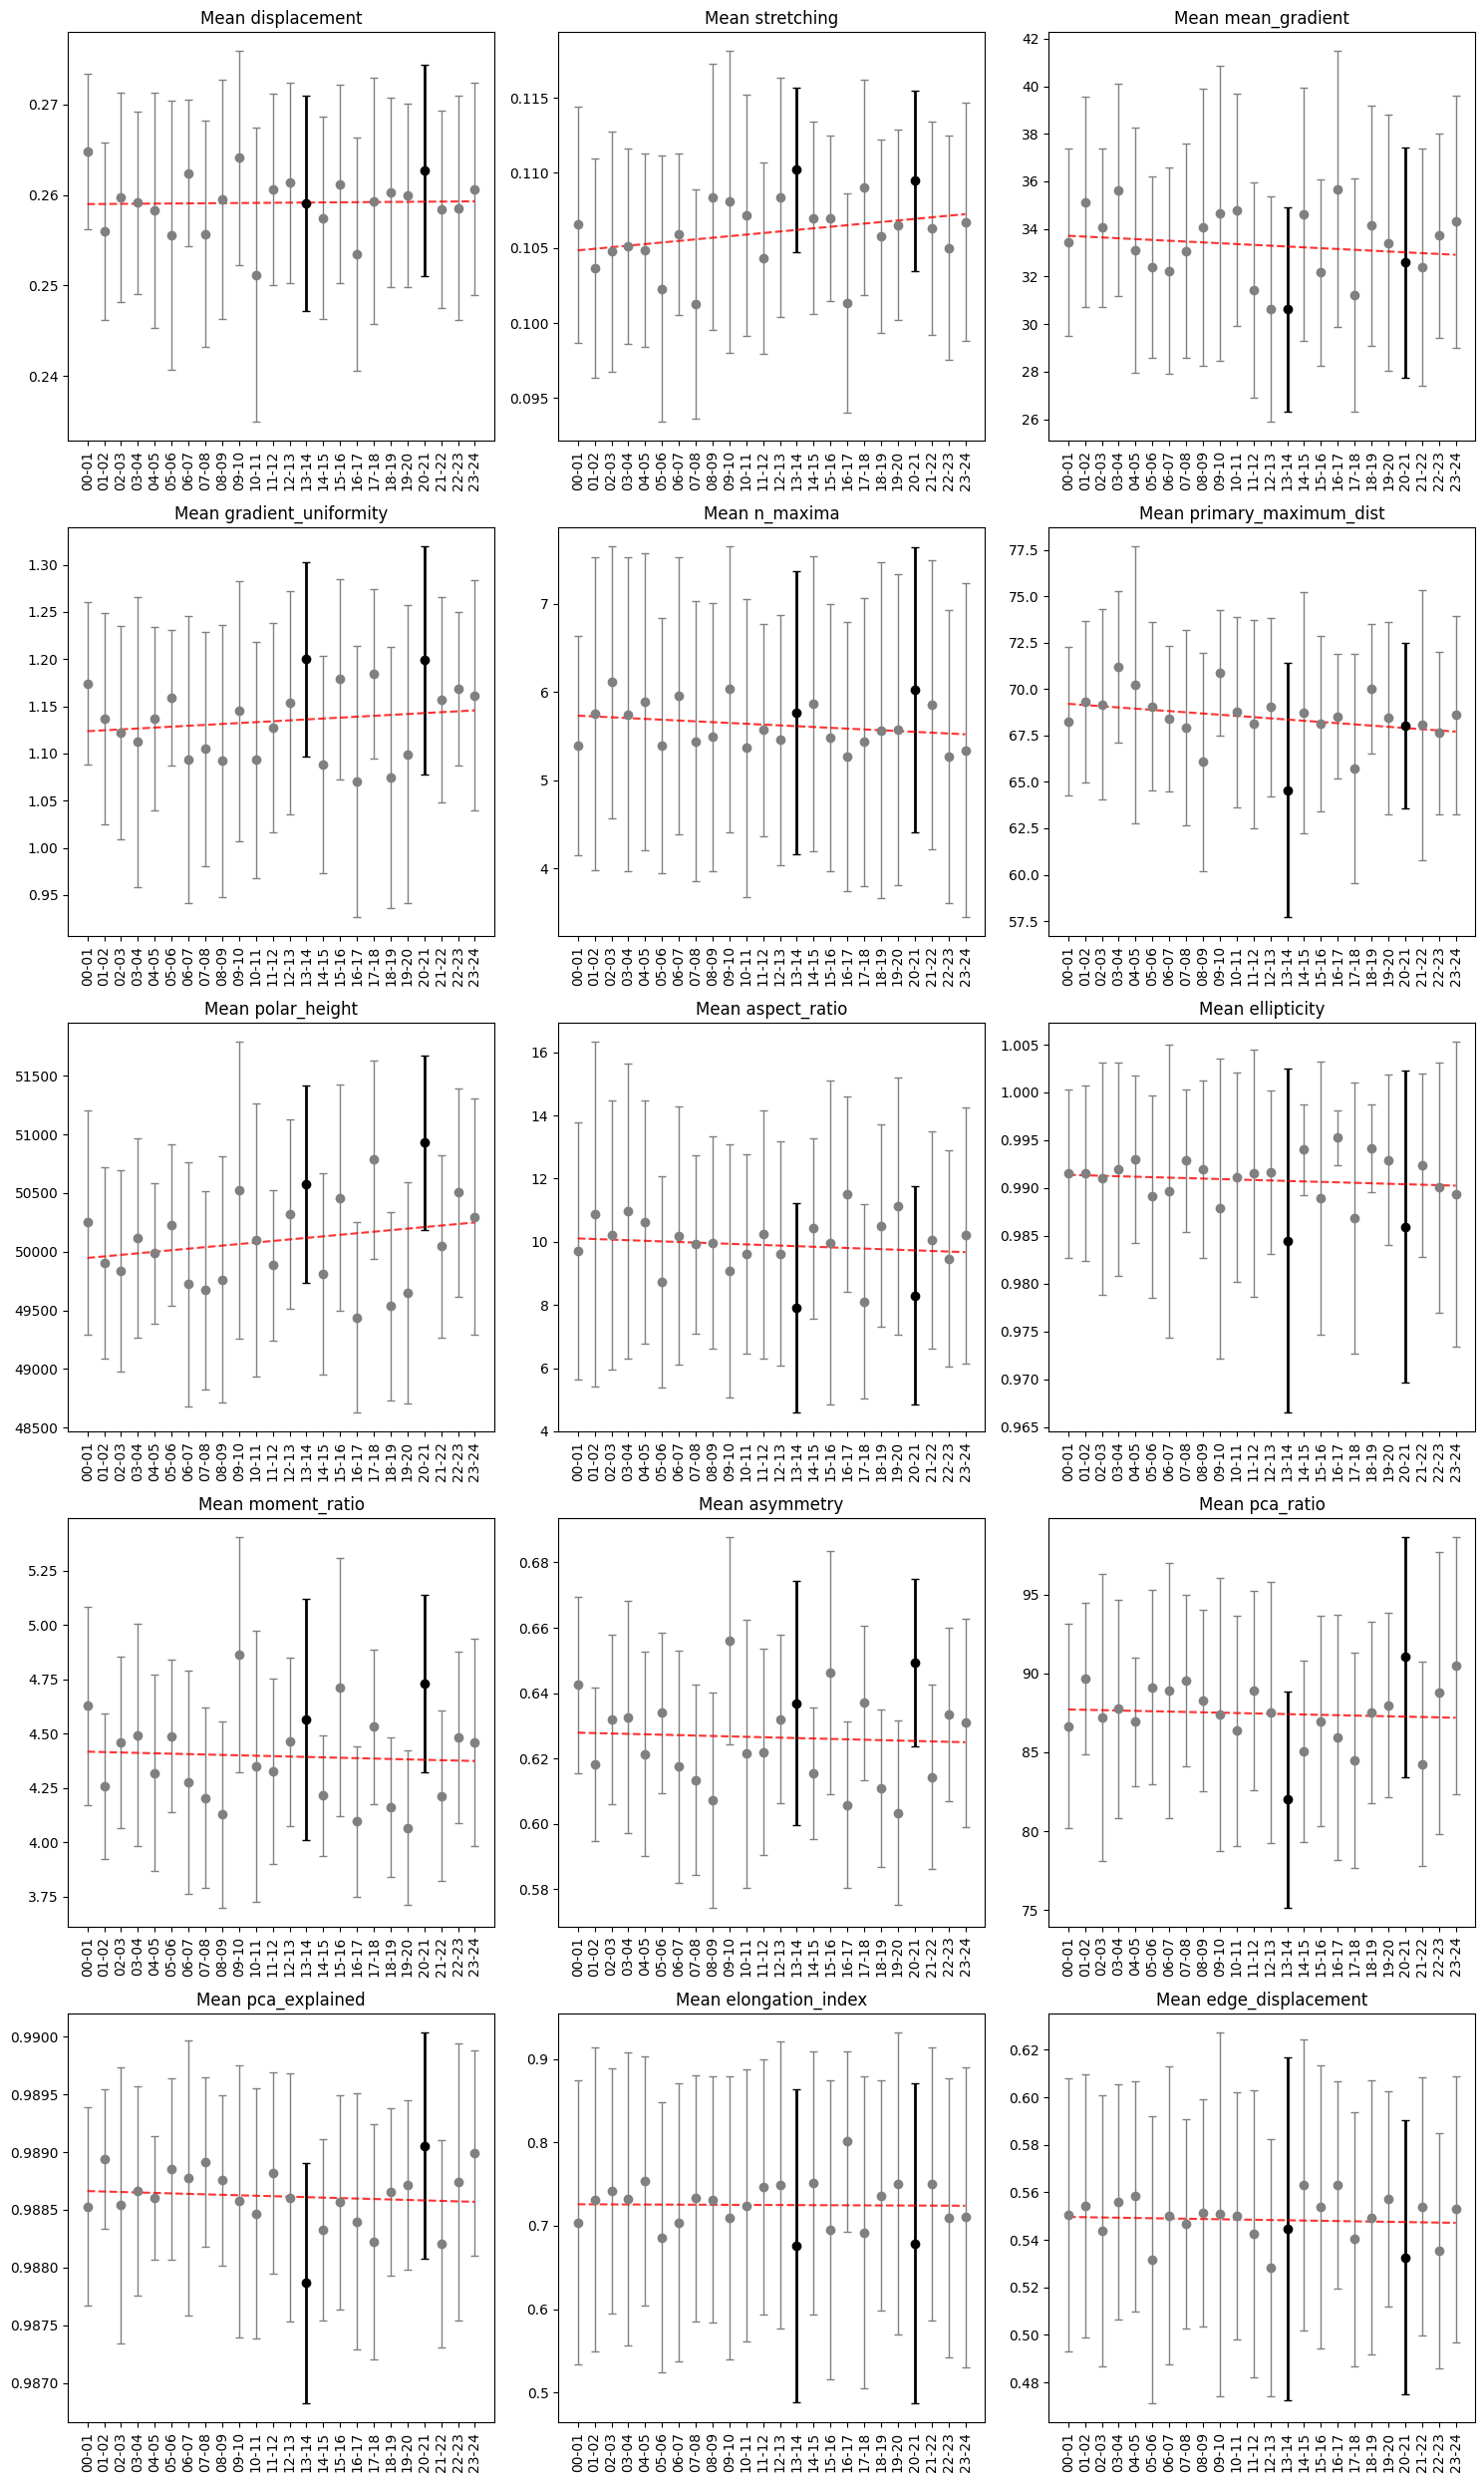

In [216]:
plot_metrics(df_500mb)


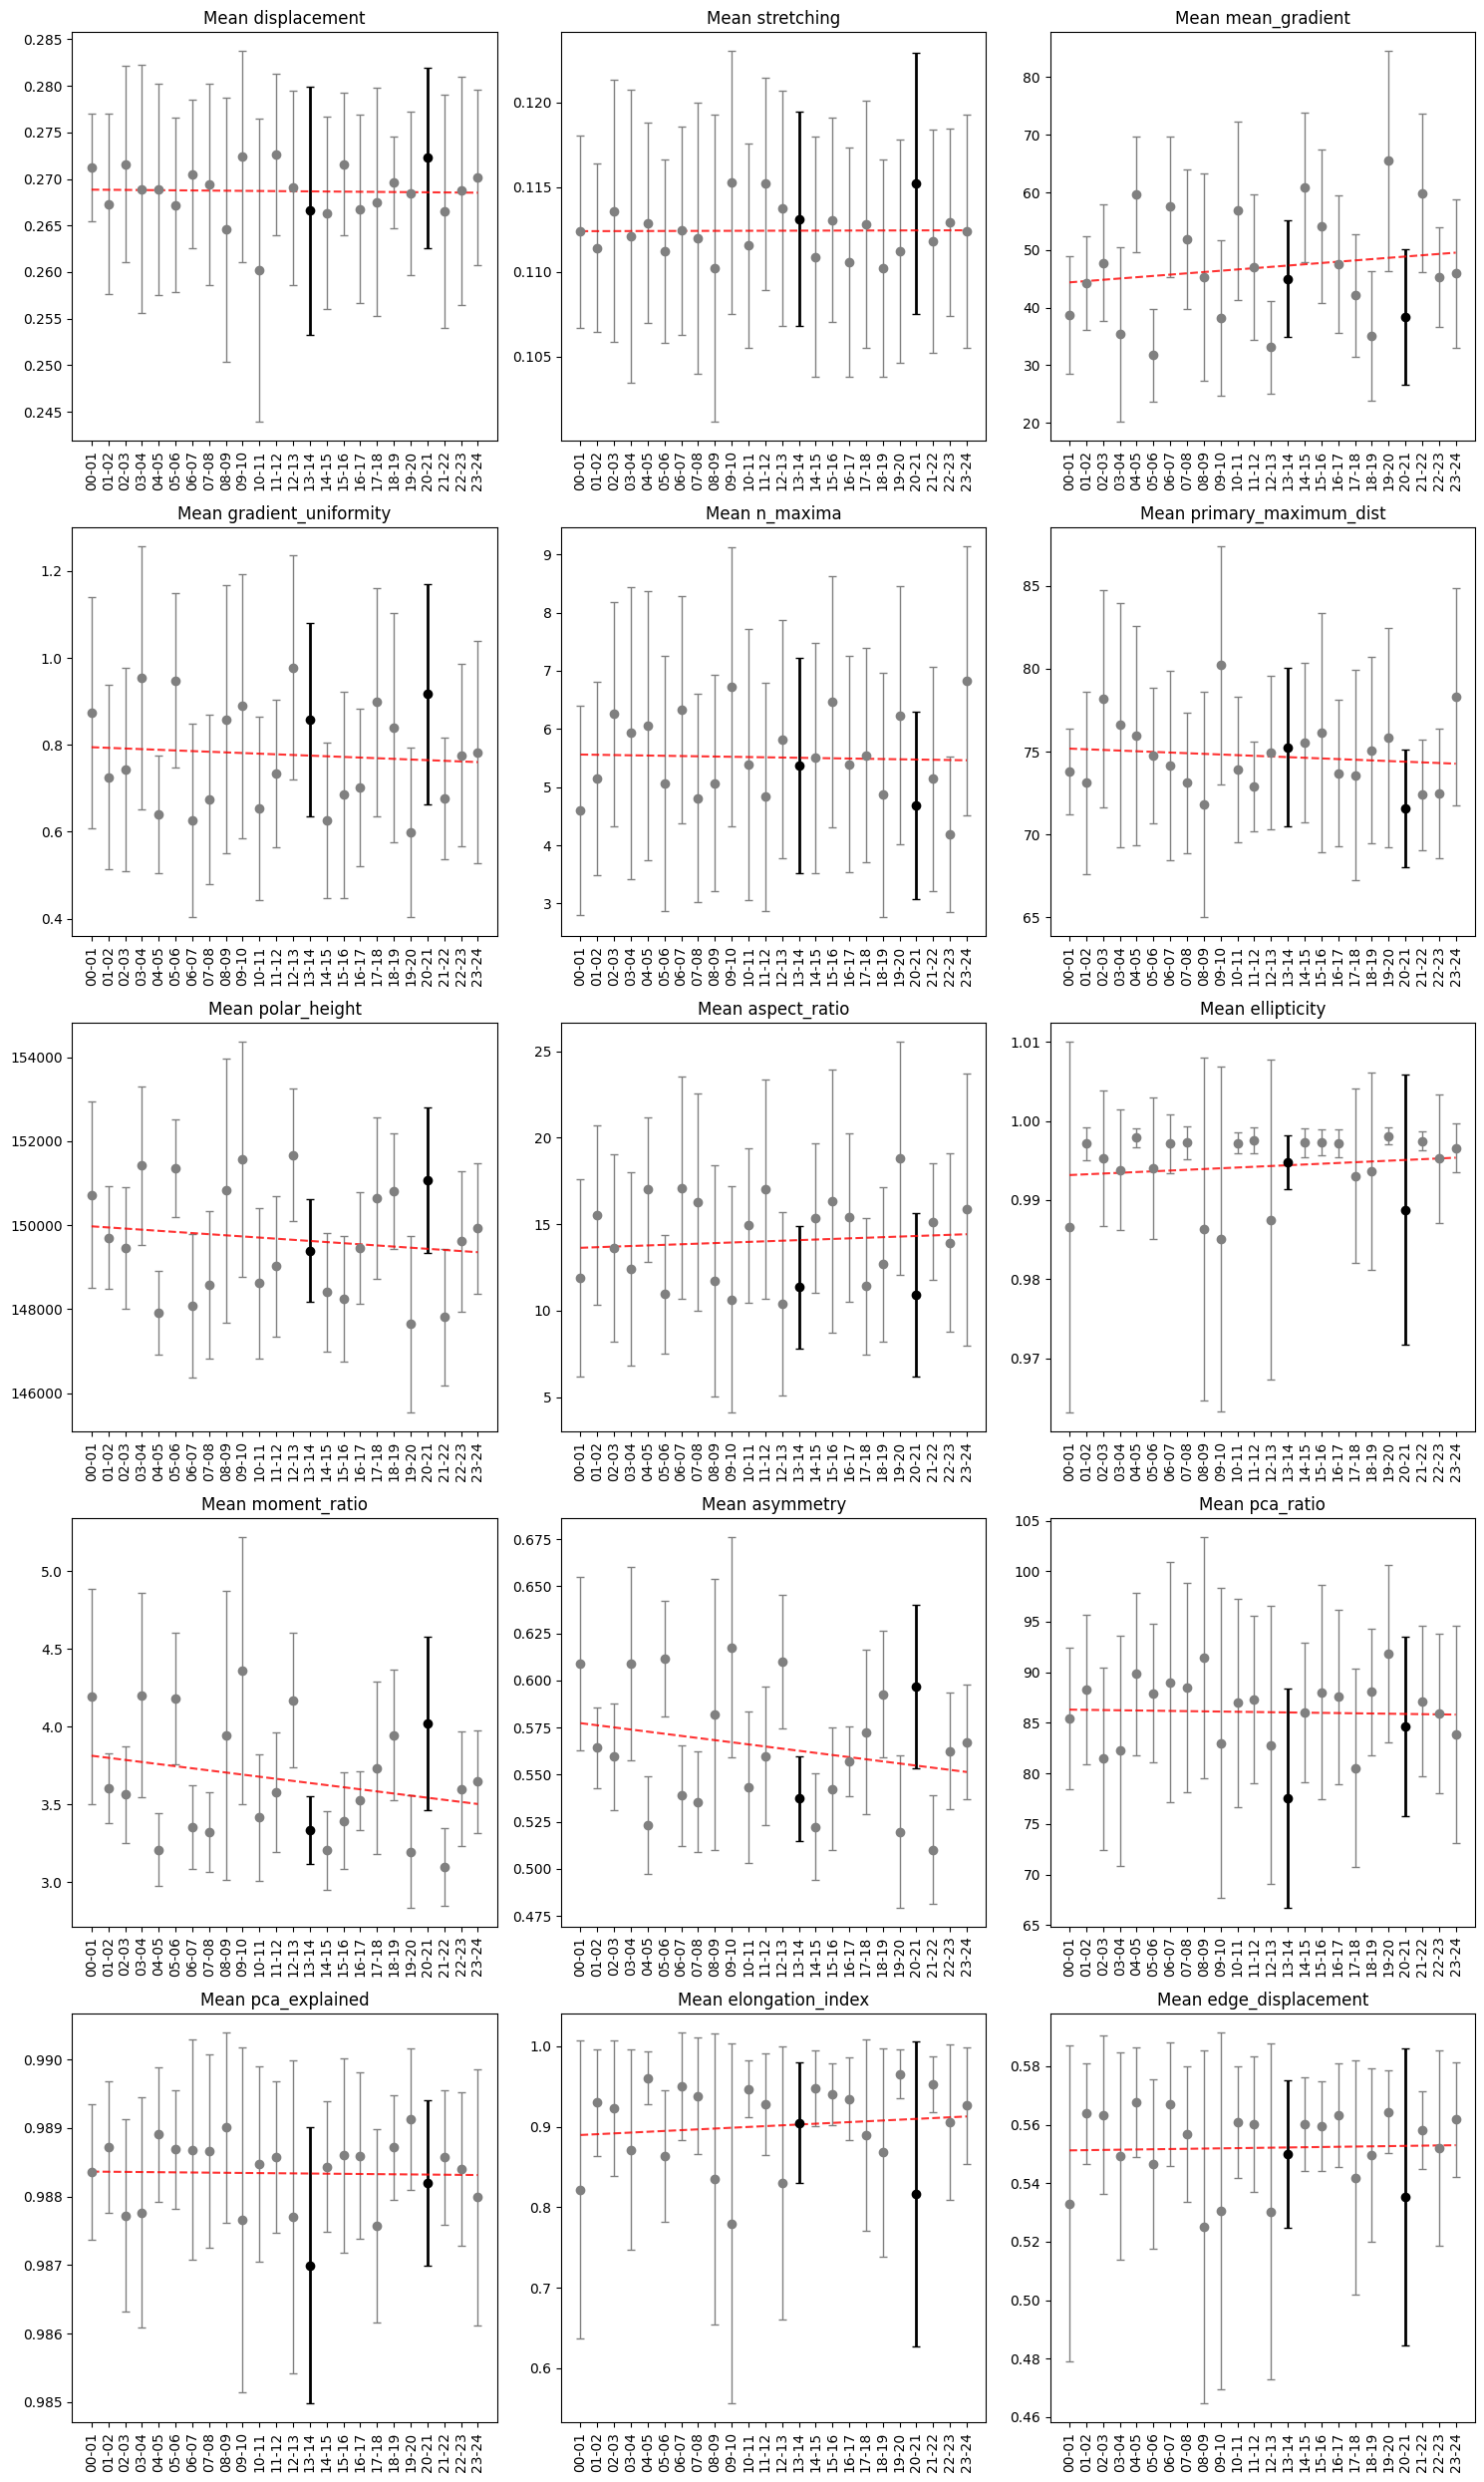

In [217]:
plot_metrics(df_100mb)

In [273]:
df_v2_500mb = pd.read_csv("_output/analysis_vortex_v2_2000_2024_500mb.csv")


In [274]:
# convert date to datetime
df_v2_500mb["date"] = pd.to_datetime(df_v2_500mb["date"])


In [275]:
# make 3 new columns of type INT, year, month, day
df_v2_500mb["year"] = df_v2_500mb["date"].dt.year
df_v2_500mb["month"] = df_v2_500mb["date"].dt.month
df_v2_500mb["day"] = df_v2_500mb["date"].dt.day

In [276]:
# drop rows where the date is not in january, february, or december
df_v2_500mb = df_v2_500mb[df_v2_500mb["month"].isin([1, 2, 12])]


In [277]:
df_v2_500mb.sample(5)

,date,wave1_amp,wave2_amp,mean_gradient,gradient_uniformity,polar_height,moment_ratio,asymmetry,year,month,day
6580,2018-01-06,0.005943,1.607016,32.037205,0.981878,50451.950128,4.526714,0.638121,2018,1,6
8404,2023-01-04,0.005188,1.661277,26.069431,1.250386,50738.339107,5.060394,0.669988,2023,1,4
4773,2013-01-25,0.004827,1.606846,28.963278,1.256356,50771.245559,5.127381,0.673596,2013,1,25
6991,2019-02-21,0.004376,1.576385,40.639317,0.966112,49923.886671,3.719462,0.576223,2019,2,21
1860,2005-02-03,0.004538,1.639276,37.346710,0.891749,50727.038967,4.228003,0.617445,2005,2,3


In [278]:
metrics = [
    "wave1_amp",
    "wave2_amp",
    "mean_gradient",
    "gradient_uniformity",
    "polar_height",
    "moment_ratio",
    "asymmetry",
]

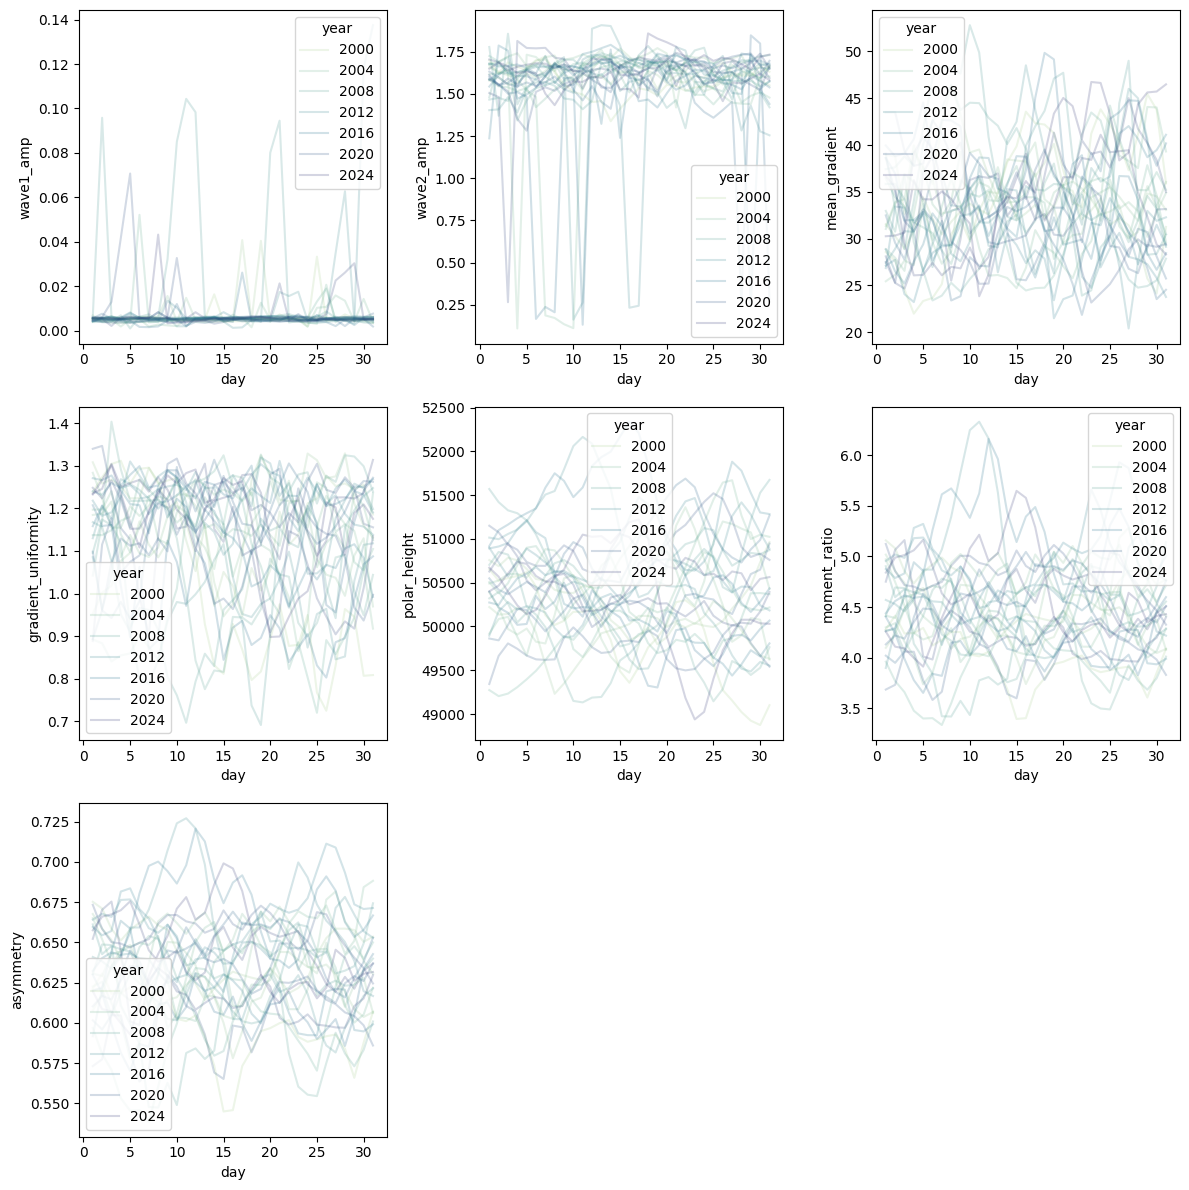

In [279]:
# make a plot of each metric for a given year and month, for all days in the month

# Create a grid of subplots
n_metrics = len(metrics)
n_rows = (n_metrics + 2) // 3  # Calculate number of rows needed for 3 columns
fig, axes = plt.subplots(n_rows, 3, figsize=(12, 4*n_rows))
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    sns.lineplot(x="day", 
                 y=metric, 
                 data=df_v2_500mb[(df_v2_500mb["month"] == 1)], 
                 hue = "year",
                 ax=axes[i],
                 palette = "crest",
                 alpha=0.2
                 )
    axes[i].set_aspect('auto')

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [289]:
df_v2_500mb.columns

Index(['date', 'wave1_amp', 'wave2_amp', 'mean_gradient',
       'gradient_uniformity', 'polar_height', 'moment_ratio', 'asymmetry',
       'year', 'month', 'day'],
      dtype='object')

In [315]:
def plot_metrics(df_input):

    df = df_input.copy()

    df["date"] = pd.to_datetime(df["date"])

    # drop all rows where the month is not january, february, or december
    df = df[df["date"].dt.month.isin([1, 2, 12])]

    df["winter_season"] = df["date"].apply(
        lambda x: (
            f"{x.year-1}-{x.year}"
            if x.month in [1, 2]
            else f"{x.year}-{x.year+1}" if x.month == 12 else None
        )
    )
    df["winter_season_short"] = df["winter_season"].apply(
        lambda x: f"{x.split('-')[0][-2:]}-{x.split('-')[1][-2:]}"
    )

    # winter_stats_df = df.groupby("winter_season_short").agg(
    #     {
    #         "wave1_amp": ["max", "min", "mean", "std"],
    #         "wave2_amp": ["max", "min", "mean", "std"],
    #         "mean_gradient": ["max", "min", "mean", "std"],
    #         "gradient_uniformity": ["max", "min", "mean", "std"],
    #         "polar_height": ["max", "min", "mean", "std"],
    #         "moment_ratio": ["max", "min", "mean", "std"],
    #         "asymmetry": ["max", "min", "mean", "std"],
    #     }
    # )

    winter_stats_df = df.groupby("winter_season_short").agg(
        {
            "wave1_amp": ["max", "min", "mean", lambda x: x.std() / np.sqrt(len(x))],
            "wave2_amp": ["max", "min", "mean", lambda x: x.std() / np.sqrt(len(x))],
            "mean_gradient": ["max","min","mean",lambda x: x.std() / np.sqrt(len(x))],
            "gradient_uniformity": ["max","min","mean",lambda x: x.std() / np.sqrt(len(x))],
            "polar_height": ["max", "min", "mean", lambda x: x.std() / np.sqrt(len(x))],
            "moment_ratio": ["max", "min", "mean", lambda x: x.std() / np.sqrt(len(x))],
            "asymmetry": ["max", "min", "mean", lambda x: x.std() / np.sqrt(len(x))],
        }
    )

    # drop the row where the winter_season_short is 99-00
    winter_stats_df = winter_stats_df[winter_stats_df.index != "99-00"]
    winter_stats_df = winter_stats_df[winter_stats_df.index != "24-25"]

    metrics = [
        "wave1_amp",
        "wave2_amp",
        "mean_gradient",
        "gradient_uniformity",
        "polar_height",
        "moment_ratio",
        "asymmetry",
    ]

    # Create a figure with subplots for each metric
    n_metrics = len(metrics)
    fig, axes = plt.subplots(4, 2, figsize=(10, 16))
    axes = axes.ravel()

    # Plot max values for each metric
    for i, metric in enumerate(metrics):
        # Get x and y values
        x = np.arange(len(winter_stats_df.index))
        y = winter_stats_df[(metric, "mean")].values
        yerr = winter_stats_df[(metric, "<lambda_0>")].values

        # Plot points with error bars
        for j, season in enumerate(winter_stats_df.index):
            if season in ["13-14", "20-21"]:
                axes[i].errorbar(
                    j, y[j], yerr=yerr[j], fmt="o", capsize=3, color="black", lw=2
                )
            else:
                axes[i].errorbar(
                    j, y[j], yerr=yerr[j], fmt="o", capsize=3, color="gray", lw=1
                )

        # Add trend line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        axes[i].plot(x, p(x), "r--", alpha=0.8)

        # Customize plot
        axes[i].set_title(f"Mean {metric}")
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(winter_stats_df.index, rotation=90)

    # Hide any empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

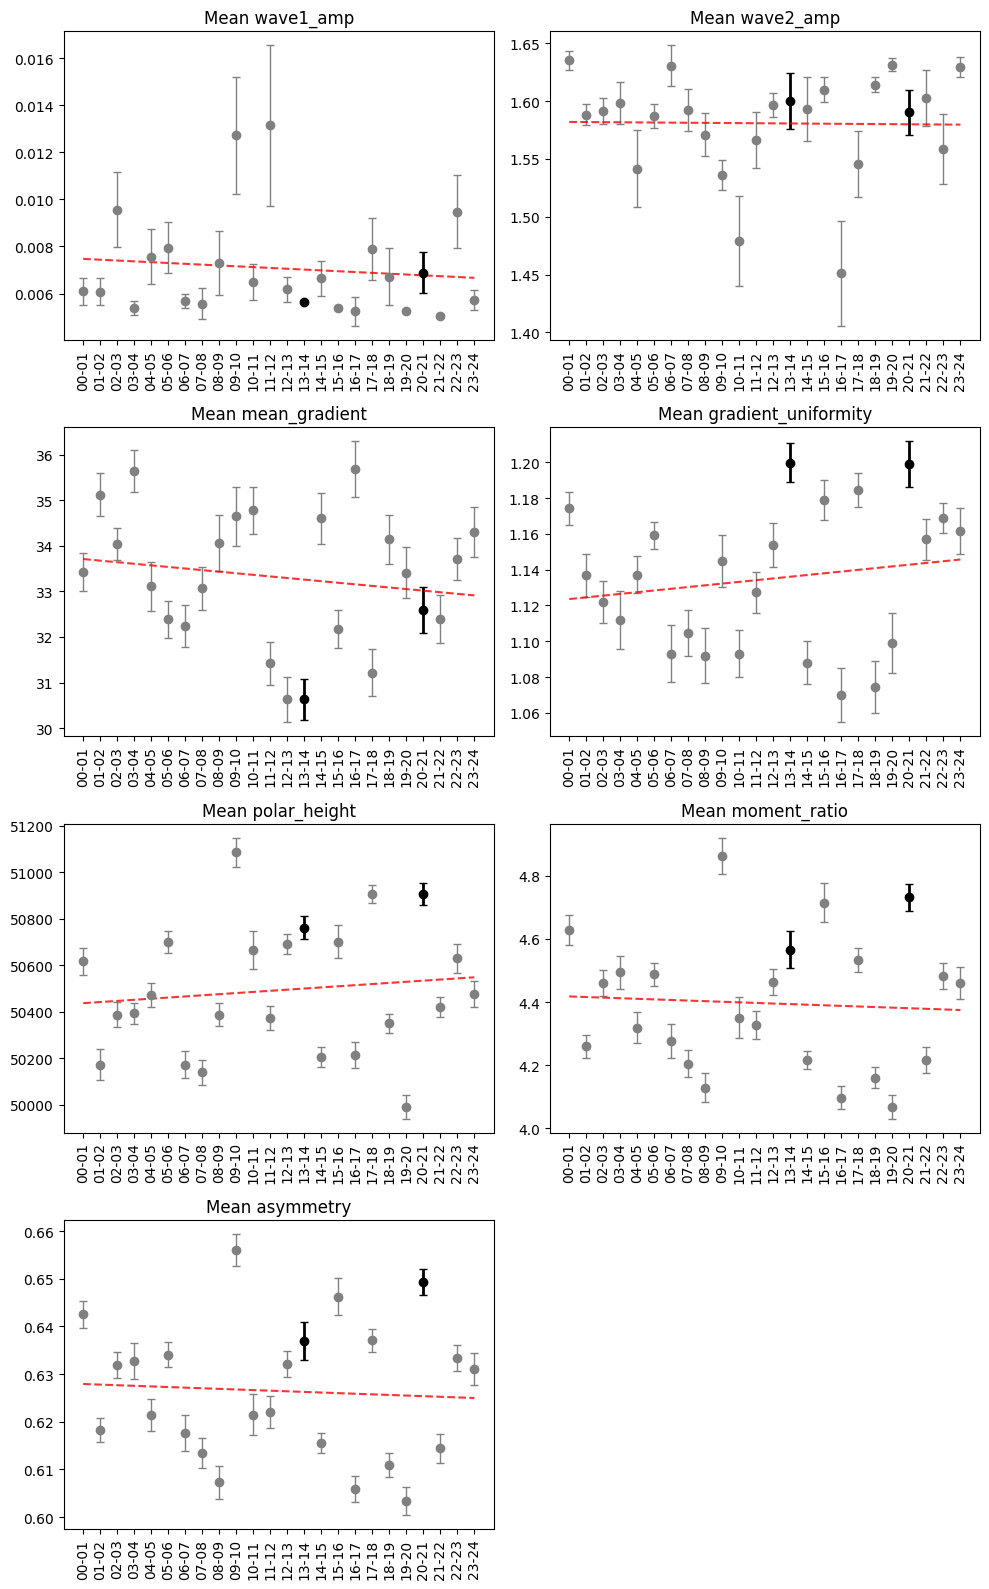

In [316]:
plot_metrics(df_v2_500mb)

In [257]:
df_seaice = pd.read_csv("_output/analysis_seaice_cover.csv")

In [285]:
df_temp_anom = pd.read_csv("_output/analysis_temperature_66.5N-90.0N.csv")

In [286]:
# df_seaice.sample(2)

In [280]:
def process_monthly_data(df_input):
    df = df_input.copy()

    # convert date to datetime
    df["date"] = pd.to_datetime(df["date"])

    df["winter_season"] = df["date"].apply(
        lambda x: (
            f"{x.year-1}-{x.year}"
            if x.month in [1, 2]
            else f"{x.year}-{x.year+1}" if x.month == 12 else None
        )
    )

    df["winter_season_short"] = df["winter_season"].apply(
        lambda x: (
            f"{x.split('-')[0][-2:]}-{x.split('-')[1][-2:]}" if x is not None else None
        )
    )
    # make a column year
    df["year"] = df["date"].dt.year
    # make a column month
    df["month"] = df["date"].dt.month
    return df


In [281]:
df_seaice = process_monthly_data(df_seaice)

In [287]:
df_temp_anom = process_monthly_data(df_temp_anom)

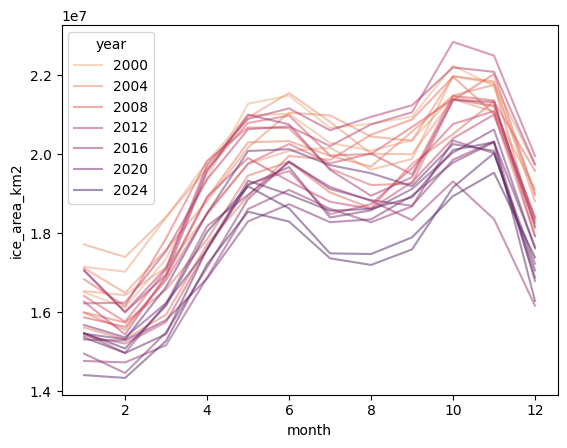

In [272]:
# plot the sea ice area for each month, with year as hue
sns.lineplot(x="month", y="ice_area_km2", data=df_seaice, hue="year", palette="flare", alpha=0.5)
plt.show()

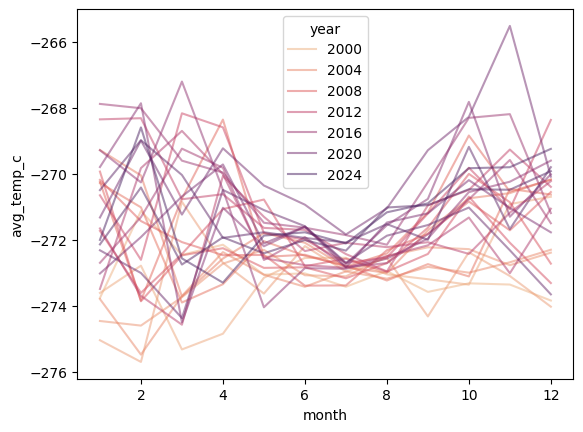

In [288]:
sns.lineplot(
    x="month", y="avg_temp_c", data=df_temp_anom, hue="year", palette="flare", alpha=0.5
)
plt.show()

In [201]:
# add a new column for the year of the winter season based on the calendar year and month. 
# for example, if the date is 2000-02-13, the year of the winter season is 1999-2000
# if the date is 2005-12-23, the year of the winter season is 2005-2006
# so if the month is january or february, the year of the winter season is the year of the date minus one
# if the month is december, the year of the winter season is the year of the date

df.sample(2)



,date,displacement,stretching,mean_gradient,gradient_uniformity,n_maxima,primary_maximum_dist,polar_height,aspect_ratio,ellipticity,moment_ratio,asymmetry,pca_ratio,pca_explained,elongation_index,edge_displacement,winter_season
4769,2013-01-21,0.270135,0.121262,32.224258,1.276220,7.0,73.0,50981.854336,9.067732,0.993900,4.831534,0.657037,72.668285,0.986426,0.780120,0.586895,2012-2013
8738,2023-12-04,0.266011,0.112988,32.936752,1.143881,5.0,67.5,52631.809805,3.927513,0.967043,5.215561,0.678227,121.277639,0.991822,0.477704,0.495890,2023-2024


In [202]:
# new column, 'winter_season_short', splitting the winter_season column into two years, then taking the last two digits of each year and joining them with a dash

df.sample(2)


,date,displacement,stretching,mean_gradient,gradient_uniformity,n_maxima,primary_maximum_dist,polar_height,aspect_ratio,ellipticity,moment_ratio,asymmetry,pca_ratio,pca_explained,elongation_index,edge_displacement,winter_season,winter_season_short
4442,2012-02-29,0.266696,0.101427,35.031254,1.257265,5.0,67.50,50470.261030,9.058170,0.993888,4.191937,0.614787,84.458784,0.988298,0.444189,0.507912,2011-2012,11-12
4057,2011-02-09,0.241725,0.103347,27.985531,1.187046,6.0,64.25,50146.702376,7.778515,0.991702,4.209996,0.616123,78.409256,0.987407,0.702595,0.615745,2010-2011,10-11


In [203]:
# get the max, min, mean, and std of all metrics for each winter_season_short
# and put them in a new dataframe



In [206]:
winter_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 00-01 to 23-24
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   (displacement, max)           24 non-null     float64
 1   (displacement, min)           24 non-null     float64
 2   (displacement, mean)          24 non-null     float64
 3   (displacement, std)           24 non-null     float64
 4   (stretching, max)             24 non-null     float64
 5   (stretching, min)             24 non-null     float64
 6   (stretching, mean)            24 non-null     float64
 7   (stretching, std)             24 non-null     float64
 8   (mean_gradient, max)          24 non-null     float64
 9   (mean_gradient, min)          24 non-null     float64
 10  (mean_gradient, mean)         24 non-null     float64
 11  (mean_gradient, std)          24 non-null     float64
 12  (gradient_uniformity, max)    24 non-null     float64
 13  (grad

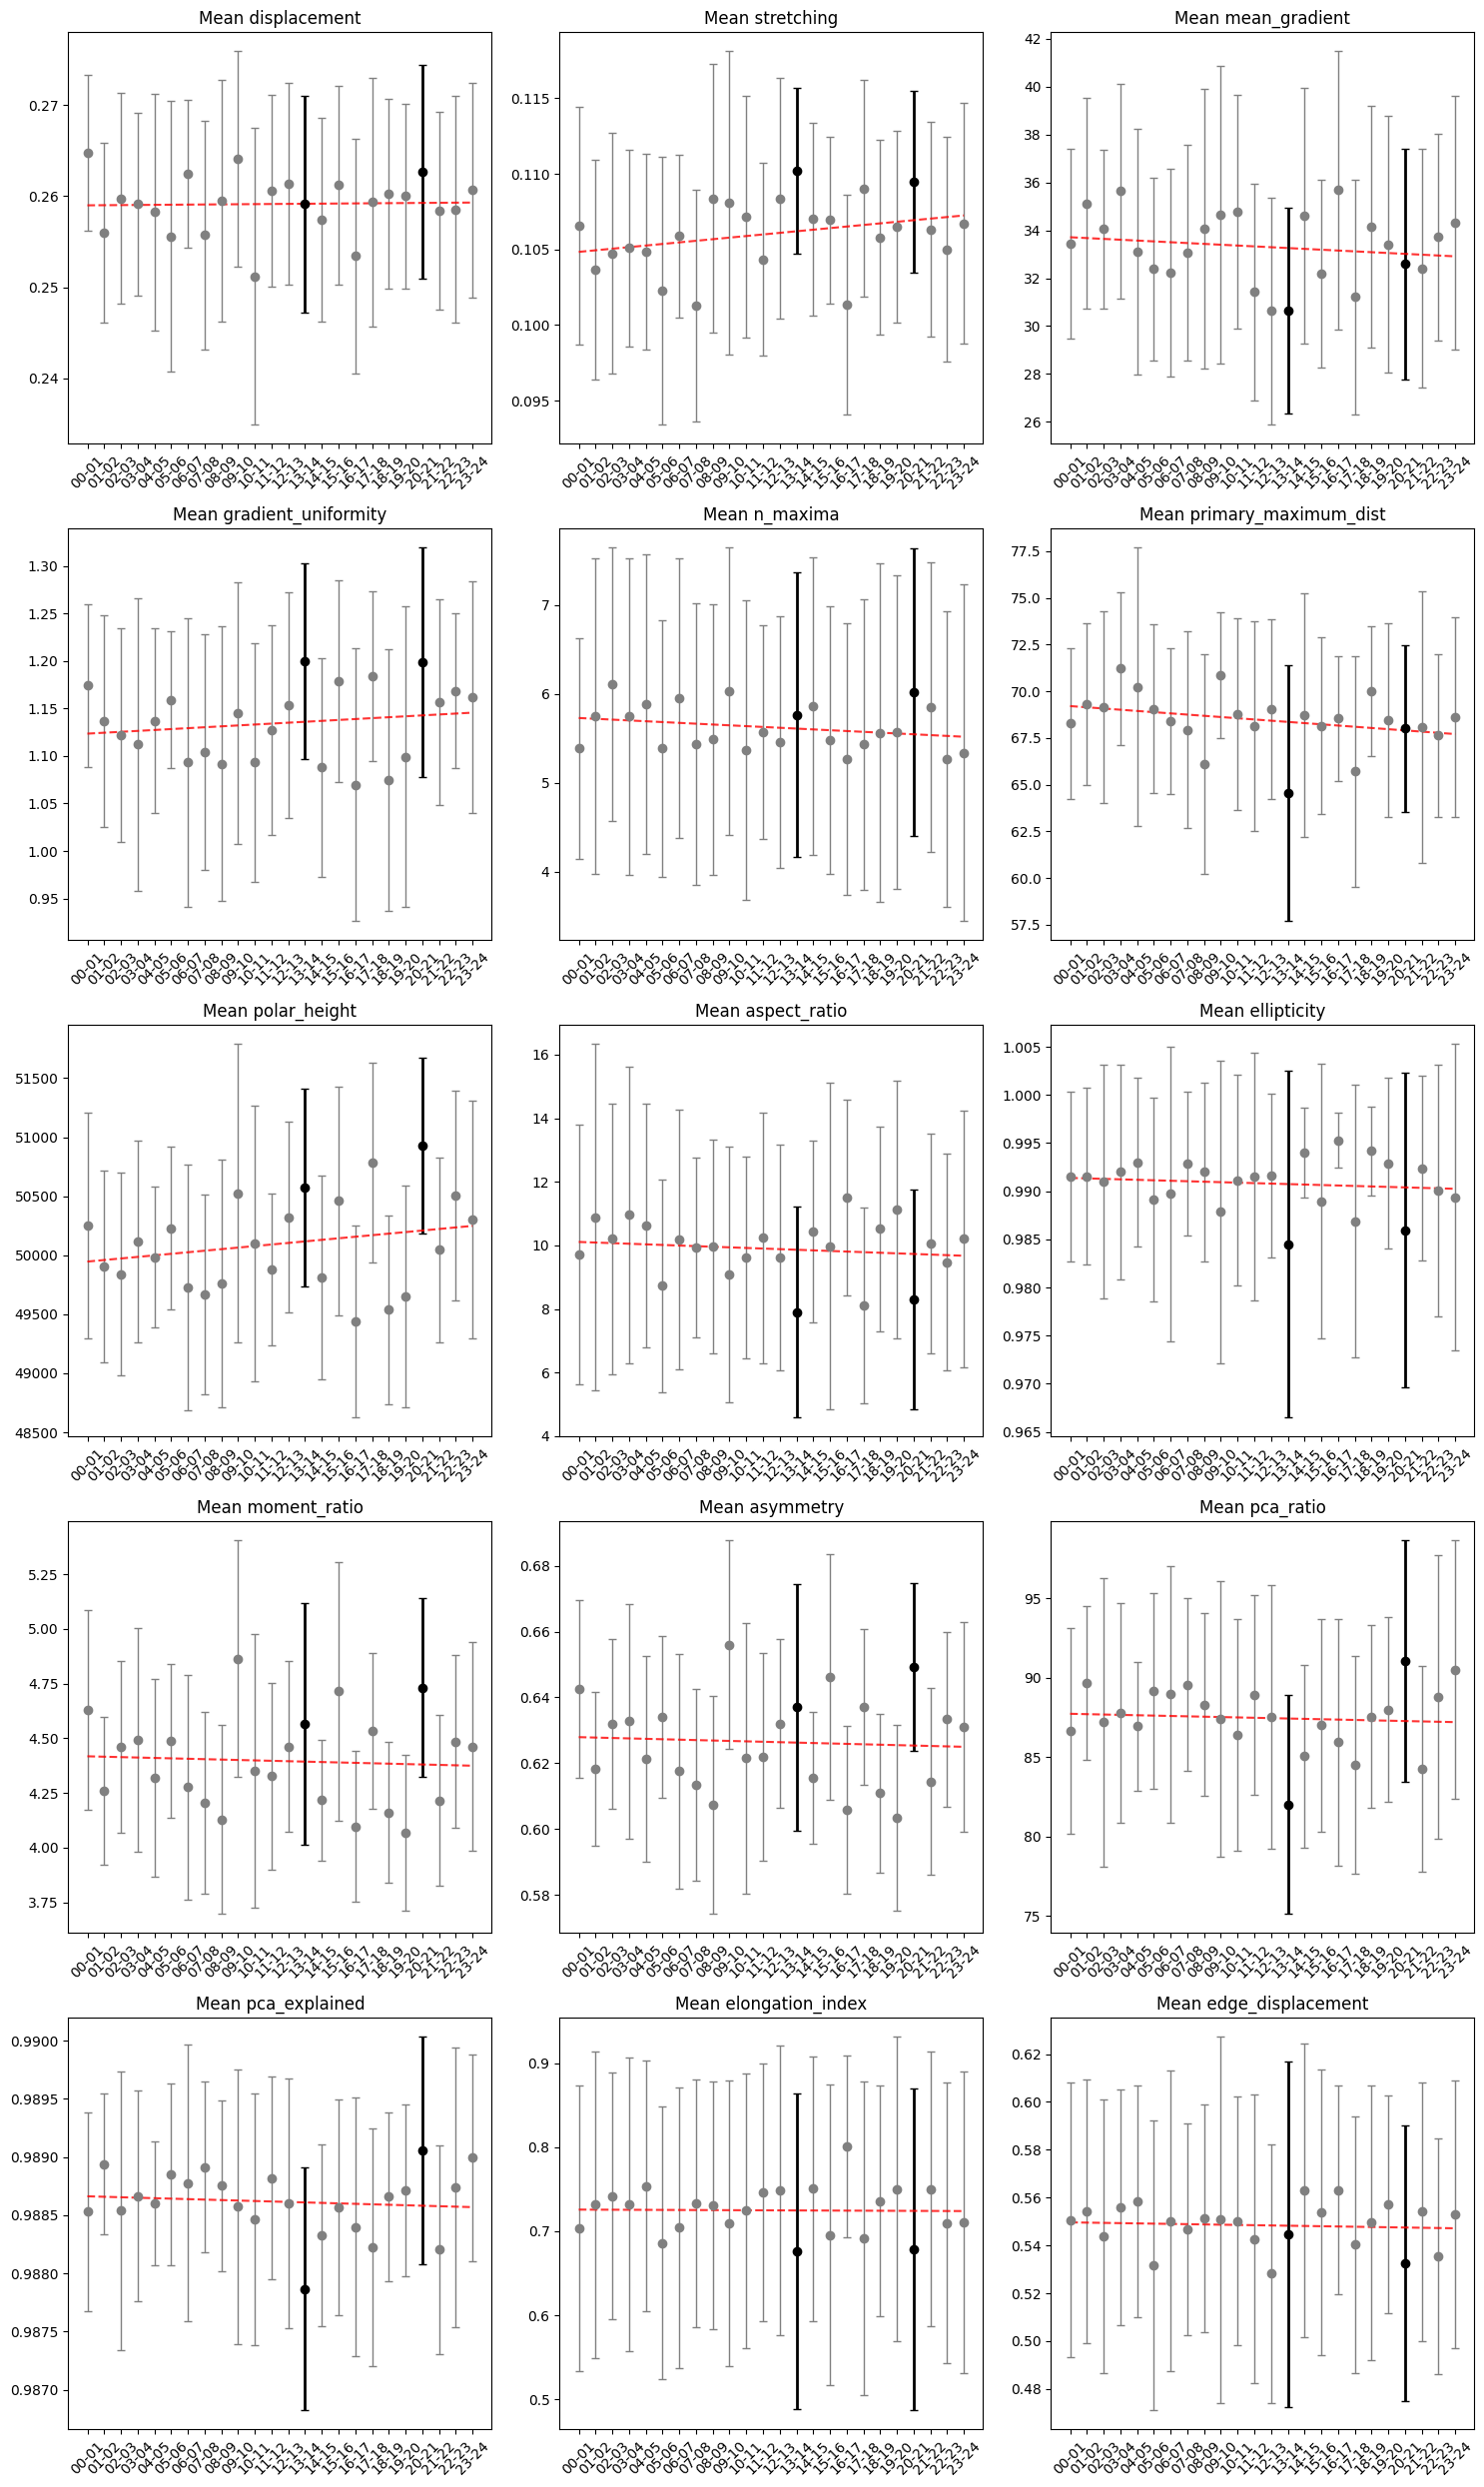

In [117]:
# df.head()

In [118]:
# df.sample(2)

In [119]:
# df.columns

In [122]:
# year column
df['year'] = pd.to_datetime(df['date']).dt.year

In [124]:
# Create yearly summary dataframe
yearly_summary = df.groupby('year').agg({
    'displacement': ['min', 'max', 'mean'],
    'stretching': ['min', 'max', 'mean'], 
    'mean_gradient': ['min', 'max', 'mean'],
    'gradient_uniformity': ['min', 'max', 'mean'],
    'n_maxima': ['min', 'max', 'mean'],
    'primary_maximum_dist': ['min', 'max', 'mean'],
    'polar_height': ['min', 'max', 'mean'],
    'aspect_ratio': ['min', 'max', 'mean'],
    'ellipticity': ['min', 'max', 'mean'],
    'moment_ratio': ['min', 'max', 'mean'],
    'asymmetry': ['min', 'max', 'mean'],
    'pca_ratio': ['min', 'max', 'mean'],
    'pca_explained': ['min', 'max', 'mean'],
    'elongation_index': ['min', 'max', 'mean'],
    'edge_displacement': ['min', 'max', 'mean']
})

# Flatten column names
yearly_summary.columns = ['_'.join(col).strip() for col in yearly_summary.columns.values]

# Reset index to make year a column
yearly_summary = yearly_summary.reset_index()




In [125]:
yearly_summary.columns

Index(['year', 'displacement_min', 'displacement_max', 'displacement_mean',
       'stretching_min', 'stretching_max', 'stretching_mean',
       'mean_gradient_min', 'mean_gradient_max', 'mean_gradient_mean',
       'gradient_uniformity_min', 'gradient_uniformity_max',
       'gradient_uniformity_mean', 'n_maxima_min', 'n_maxima_max',
       'n_maxima_mean', 'primary_maximum_dist_min', 'primary_maximum_dist_max',
       'primary_maximum_dist_mean', 'polar_height_min', 'polar_height_max',
       'polar_height_mean', 'aspect_ratio_min', 'aspect_ratio_max',
       'aspect_ratio_mean', 'ellipticity_min', 'ellipticity_max',
       'ellipticity_mean', 'moment_ratio_min', 'moment_ratio_max',
       'moment_ratio_mean', 'asymmetry_min', 'asymmetry_max', 'asymmetry_mean',
       'pca_ratio_min', 'pca_ratio_max', 'pca_ratio_mean', 'pca_explained_min',
       'pca_explained_max', 'pca_explained_mean', 'elongation_index_min',
       'elongation_index_max', 'elongation_index_mean',
       'edge_dis

In [126]:
# get names of all columns in yearly_summary that end with _max
max_cols = [col for col in yearly_summary.columns if col.endswith('_max')]
mean_cols = [col for col in yearly_summary.columns if col.endswith("_mean")]
min_cols = [col for col in yearly_summary.columns if col.endswith("_min")]


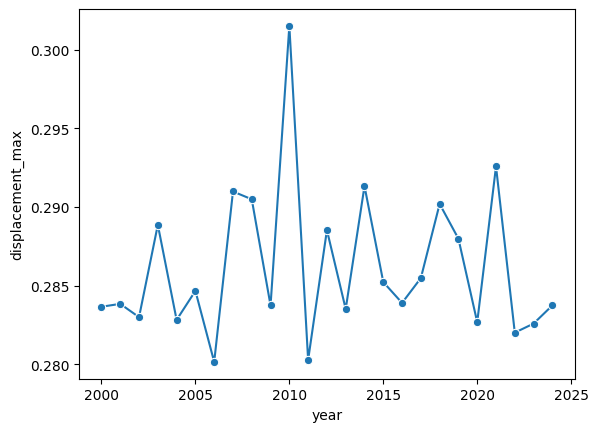

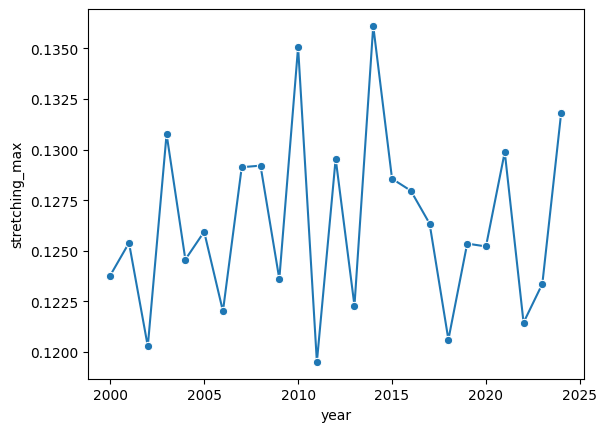

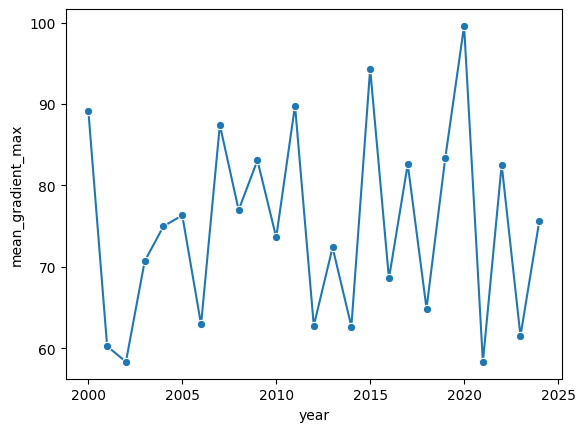

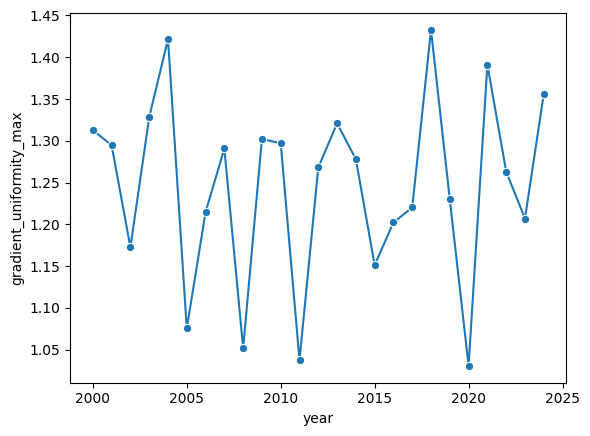

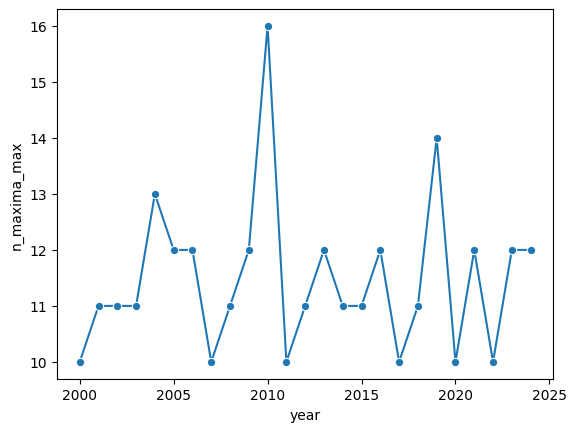

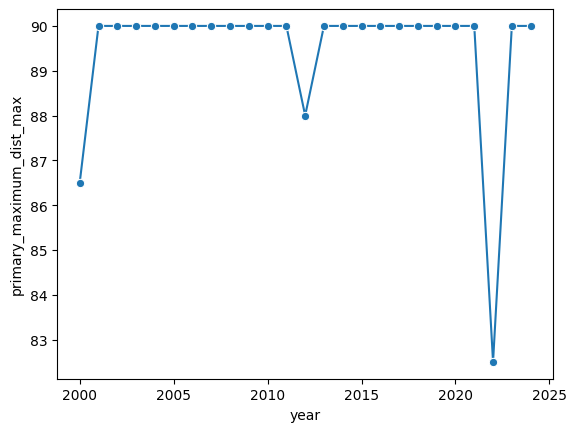

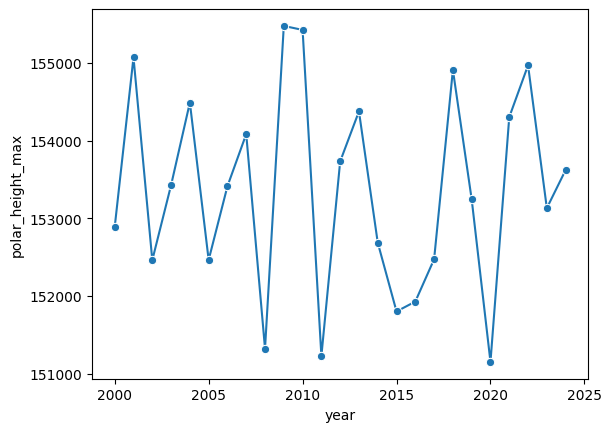

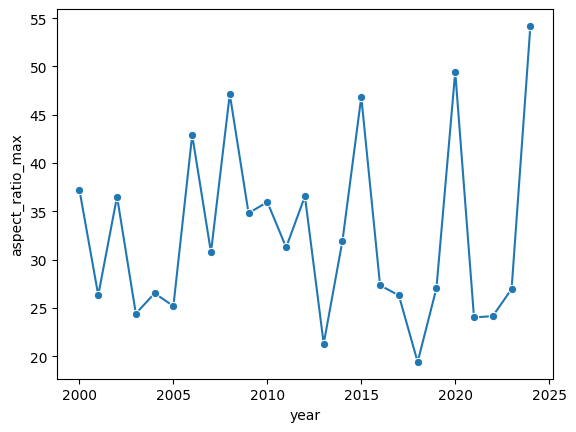

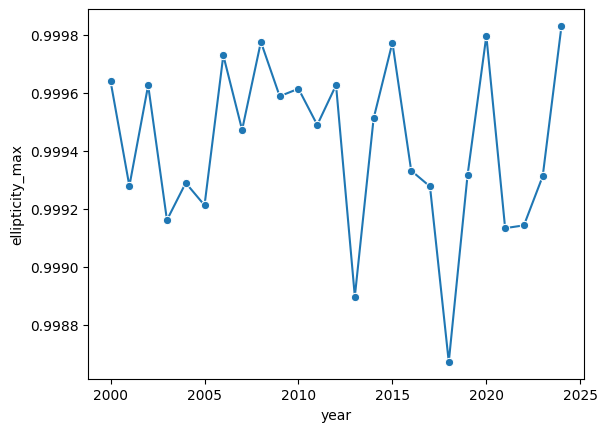

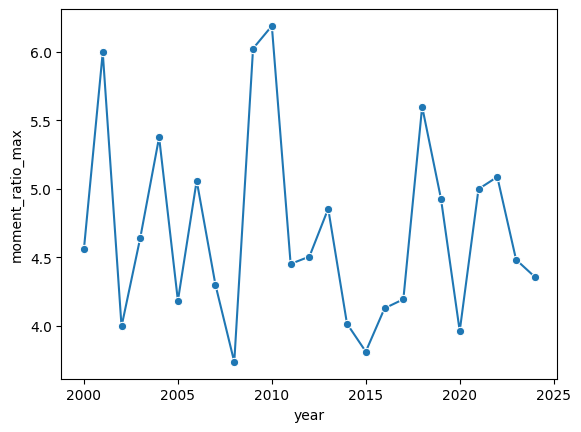

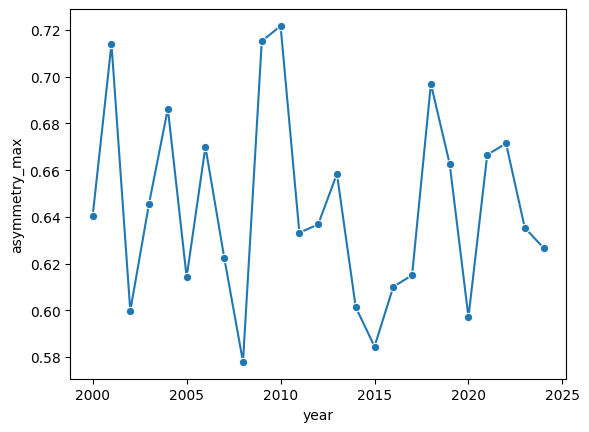

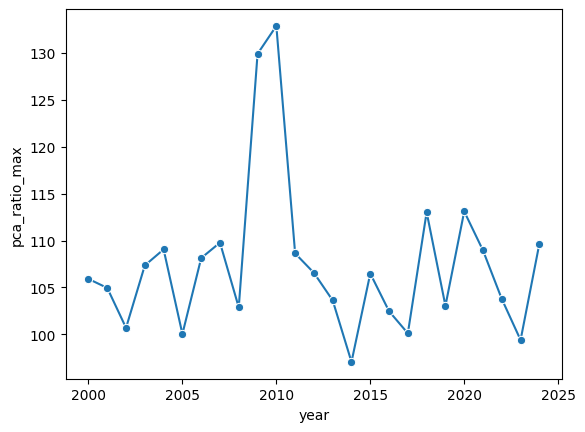

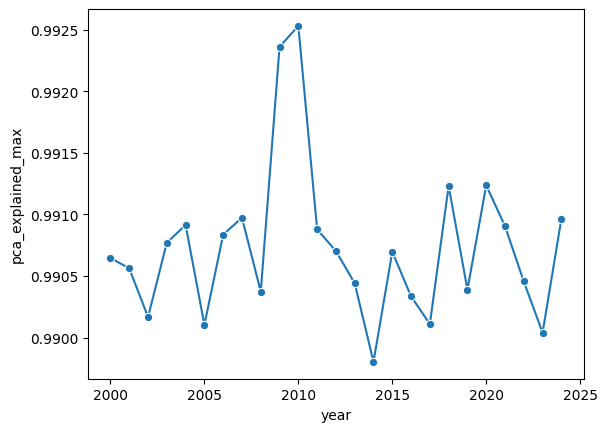

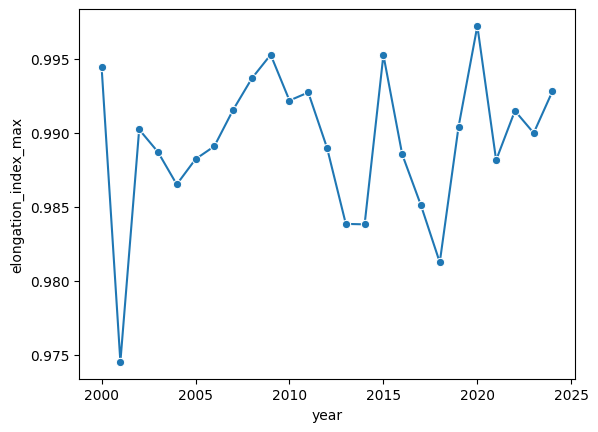

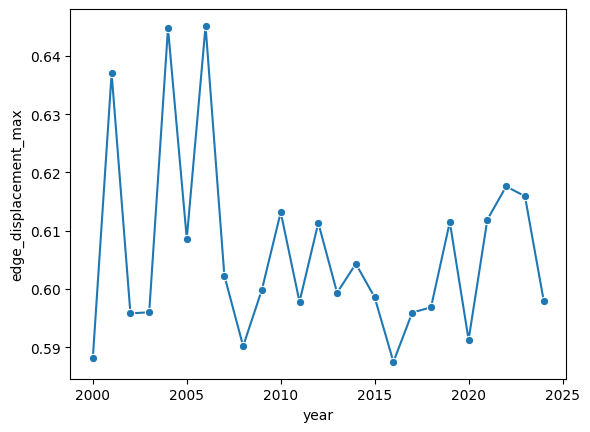

In [127]:
for col in max_cols:
    sns.lineplot(x='year', y=col, data=yearly_summary, marker='o')
    plt.show()

In [83]:
import shutil

# Get list of files from df_dlat
files_to_copy = df_dlat['filename'].tolist()

# Create _traj directory if it doesn't exist
traj_dir = Path("_output/_traj")
traj_dir.mkdir(exist_ok=True)

# Copy and rename files
for filename in files_to_copy:
    # Get year from filename
    year = filename.split("_")[2][:4]
    
    # Source and destination paths
    src = Path("_output") / filename
    dst = traj_dir / f"max_dlat_{year}.csv"
    
    # Copy file
    shutil.copy2(src, dst)


In [82]:
df_dlat["filename"].tolist()

['jetstream_traj_2000-01-21T00:00:00.000000000.csv',
 'jetstream_traj_2001-01-08T00:00:00.000000000.csv',
 'jetstream_traj_2002-01-01T00:00:00.000000000.csv',
 'jetstream_traj_2003-02-07T00:00:00.000000000.csv',
 'jetstream_traj_2004-02-11T00:00:00.000000000.csv',
 'jetstream_traj_2005-01-04T00:00:00.000000000.csv',
 'jetstream_traj_2006-02-16T00:00:00.000000000.csv',
 'jetstream_traj_2007-02-01T00:00:00.000000000.csv',
 'jetstream_traj_2008-01-20T00:00:00.000000000.csv',
 'jetstream_traj_2009-01-19T00:00:00.000000000.csv',
 'jetstream_traj_2010-02-04T00:00:00.000000000.csv',
 'jetstream_traj_2011-02-01T00:00:00.000000000.csv',
 'jetstream_traj_2012-02-09T00:00:00.000000000.csv',
 'jetstream_traj_2013-01-14T00:00:00.000000000.csv',
 'jetstream_traj_2014-01-30T00:00:00.000000000.csv',
 'jetstream_traj_2015-01-08T00:00:00.000000000.csv',
 'jetstream_traj_2016-02-09T00:00:00.000000000.csv',
 'jetstream_traj_2017-01-06T00:00:00.000000000.csv',
 'jetstream_traj_2018-01-15T00:00:00.000000000

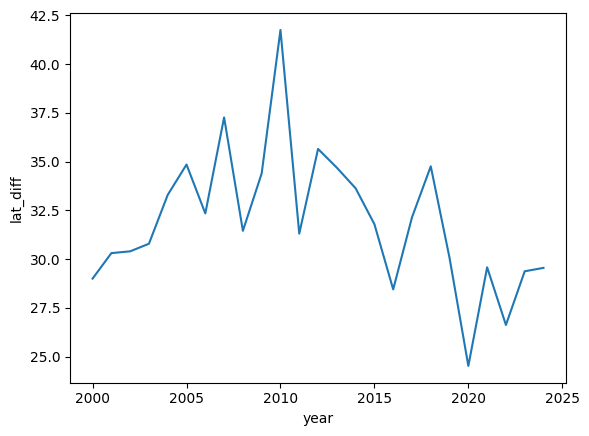

In [67]:
sns.lineplot(x="year", y="lat_diff", data=df_dlat)
plt.show()

In [68]:
df_all = pd.read_csv('_output/all_latitude_ranges.csv')

In [69]:
df_all.dtypes

date         object
filename     object
lat_diff    float64
max_lat     float64
min_lat     float64
dtype: object

In [70]:
df_all["month_date"] = pd.to_datetime(df_all["date"]).dt.strftime("%m-%d")

In [71]:
df_all['year'] = pd.to_datetime(df_all['date']).dt.year


In [72]:
df_all.sample(2)

,date,filename,lat_diff,max_lat,min_lat,month_date,year
173,2007-02-19,jetstream_traj_2007-02-19T00:00:00.000000000.csv,10.741854,44.405022,33.663168,02-19,2007
880,2003-01-07,jetstream_traj_2003-01-07T00:00:00.000000000.csv,25.436971,60.515778,35.078807,01-07,2003


In [73]:
df_all.dtypes

date           object
filename       object
lat_diff      float64
max_lat       float64
min_lat       float64
month_date     object
year            int32
dtype: object

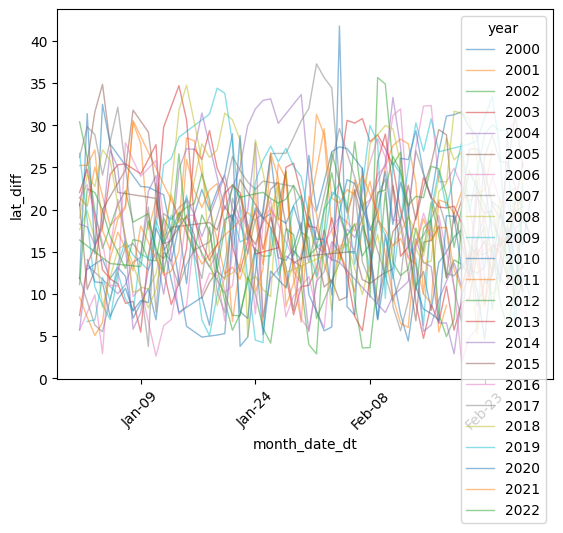

In [74]:
import matplotlib.dates as mdates

# Convert month-date to datetime for proper sorting
df_all['month_date_dt'] = pd.to_datetime('2000-' + df_all['month_date'])

sns.lineplot(x="month_date_dt", 
                y="lat_diff", 
                hue="year", 
                data=df_all[df_all['year'] < 2023],
                palette='tab10', 
                linewidth=1, alpha=0.5
                )

# Set x-axis ticks to show dates every 2 weeks
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.xticks(rotation=45)
plt.show()


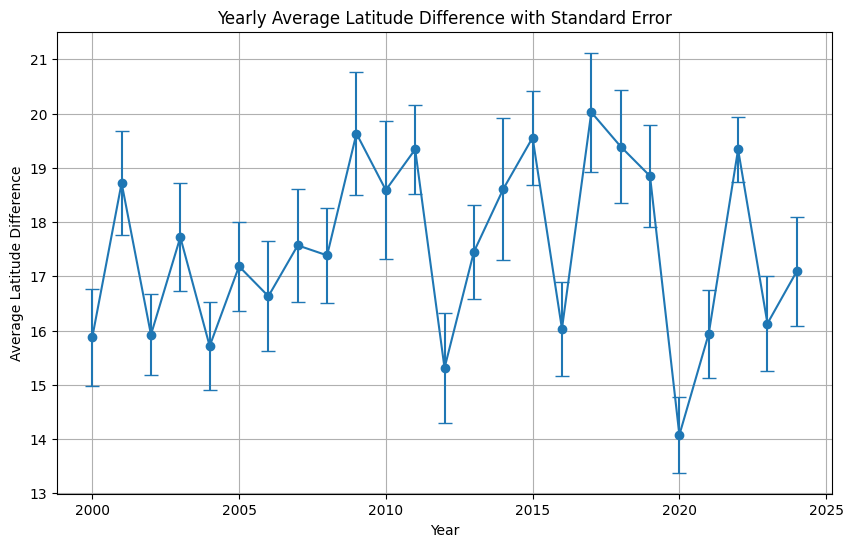

In [75]:
# Calculate yearly means and standard errors
yearly_stats = df_all.groupby('year')['lat_diff'].agg(['mean', 'std', 'count']).reset_index()
yearly_stats['se'] = yearly_stats['std'] / np.sqrt(yearly_stats['count'])

# Create the plot
plt.figure(figsize=(10,6))
plt.errorbar(yearly_stats['year'], 
            yearly_stats['mean'],
            yerr=yearly_stats['se'],
            fmt='o-',
            capsize=5)

plt.xlabel('Year')
plt.ylabel('Average Latitude Difference')
plt.title('Yearly Average Latitude Difference with Standard Error')
plt.grid(True)
plt.show()


In [76]:
df_all.dtypes


date                     object
filename                 object
lat_diff                float64
max_lat                 float64
min_lat                 float64
month_date               object
year                      int32
month_date_dt    datetime64[ns]
dtype: object

In [77]:
df_all.sample(2)

,date,filename,lat_diff,max_lat,min_lat,month_date,year,month_date_dt
573,2006-02-09,jetstream_traj_2006-02-09T00:00:00.000000000.csv,24.20807,59.155448,34.947378,02-09,2006,2000-02-09
139,2019-02-24,jetstream_traj_2019-02-24T00:00:00.000000000.csv,30.05540,70.055031,39.999631,02-24,2019,2000-02-24


In [78]:
# Convert date to datetime if not already
df_all["date"] = pd.to_datetime(df_all["date"])

# Define the date ranges
ranges = [
    ("2014-01-03", "2014-01-07"),
    ("2019-01-29", "2019-01-31"),
    ("2021-02-13", "2021-02-17"),
    ("2023-02-03", "2023-02-04"),
]

# Calculate overall mean
overall_mean = df_all["lat_diff"].mean()

# Create list to store results
results = []

# Analyze each range
for start_date, end_date in ranges:
    # Get data for this range
    mask = (df_all["date"] >= start_date) & (df_all["date"] <= end_date)
    range_data = df_all[mask]

    # Get year and calculate year's mean
    year = pd.to_datetime(start_date).year
    year_data = df_all[df_all["date"].dt.year == year]
    year_mean = year_data["lat_diff"].mean()

    # Calculate range mean
    range_mean = range_data["lat_diff"].mean()

    results.append(
        {
            "Date Range": f"{start_date} to {end_date}",
            "Range Mean": range_mean,
            "Mean of Year": year_mean,
            "Overall Mean": overall_mean,
            "Diff from Year": range_mean - year_mean,
            "Diff from Overall": range_mean - overall_mean,
        }
    )

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Display with better formatting
pd.set_option("display.max_colwidth", None)
display(df_results)

,Date Range,Range Mean,Mean of Year,Overall Mean,Diff from Year,Diff from Overall
0,2014-01-03 to 2014-01-07,20.342325,18.607317,17.436276,1.735008,2.906049
1,2019-01-29 to 2019-01-31,22.741574,18.847303,17.436276,3.894271,5.305298
2,2021-02-13 to 2021-02-17,14.966222,15.940663,17.436276,-0.974441,-2.470054
3,2023-02-03 to 2023-02-04,14.599290,16.129422,17.436276,-1.530132,-2.836986


In [3]:
def find_temp_gradient_line(temp, lats, lons):
    # Convert xarray to numpy if needed
    temp = temp.values if isinstance(temp, xr.DataArray) else temp
    lats = lats.values if isinstance(lats, xr.DataArray) else lats
    lons = lons.values if isinstance(lons, xr.DataArray) else lons

    # Focus on Northern Hemisphere
    lat_mask = (lats >= 35) & (lats <= 80)
    nh_temp = temp[lat_mask]
    nh_lats = lats[lat_mask]

    # Pre-smooth temperature field
    nh_temp = savgol_filter(nh_temp, window_length=7, polyorder=2, axis=0)

    # Initialize output
    gradient_lats = np.zeros(len(lons))

    for i in range(len(lons)):
        # Get temperature profile at this longitude
        temp_profile = nh_temp[:, i]

        # Find points where temperature is between -20 and -10
        temp_mask = (temp_profile >= -20) & (temp_profile <= -10)

        if np.any(temp_mask):
            # Calculate temperature gradient
            temp_grad = np.gradient(temp_profile)

            # Only consider gradients where temperature is in range
            grad_strength = np.abs(temp_grad) * temp_mask

            # Find maximum gradient point
            max_grad_idx = np.argmax(grad_strength)
            gradient_lats[i] = nh_lats[max_grad_idx]
        else:
            # Fallback to previous point or mean latitude
            if i > 0:
                gradient_lats[i] = gradient_lats[i - 1]
            else:
                gradient_lats[i] = np.mean(nh_lats)

    # Smooth the line
    gradient_lats = savgol_filter(gradient_lats, window_length=51, polyorder=3)

    # Force matching ends for periodic boundary
    avg_end = (gradient_lats[0] + gradient_lats[-1]) / 2
    gradient_lats[0] = avg_end
    gradient_lats[-1] = avg_end

    return gradient_lats

In [4]:
def find_jet_ridge_position_hessian_eigenval(wind_magnitude, lats, lons):
    # Convert xarray to numpy if needed
    wind_magnitude = (
        wind_magnitude.values
        if isinstance(wind_magnitude, xr.DataArray)
        else wind_magnitude
    )
    lats = lats.values if isinstance(lats, xr.DataArray) else lats
    lons = lons.values if isinstance(lons, xr.DataArray) else lons

    # Focus on Northern Hemisphere band
    lat_mask = (lats >= 35) & (lats <= 80)
    nh_winds = wind_magnitude[lat_mask]
    nh_lats = lats[lat_mask]

    # Pre-smooth the wind field more aggressively
    nh_winds = savgol_filter(nh_winds, window_length=7, polyorder=2, axis=0)

    # Initialize outputs
    initial_lats = np.zeros(len(lons))
    uncertainties = np.zeros(len(lons))

    # First pass to get initial positions
    for i in range(len(lons)):
        # Compute local Hessian
        lat_grad = np.gradient(nh_winds[:, i])  # Changed this line
        lat_grad_2 = np.gradient(lat_grad)
        H = np.array(
            [
                [lat_grad_2[:-1], np.zeros_like(lat_grad_2[:-1])],
                [np.zeros_like(lat_grad_2[:-1]), np.zeros_like(lat_grad_2[:-1])],
            ]
        )

        # Compute eigenvalues at each latitude
        eigenvals = np.zeros((len(lat_grad_2) - 1, 2))
        for j in range(len(lat_grad_2) - 1):
            eigenvals[j] = np.linalg.eigvals(H[:, :, j])
        min_eigenvals = np.min(eigenvals, axis=1)

        # Stronger northern preference
        latitude_weight = 1 + 0.5 * (nh_lats[:-1] - np.min(nh_lats[:-1])) / (
            np.max(nh_lats[:-1]) - np.min(nh_lats[:-1])
        )
        ridge_strength = -min_eigenvals * nh_winds[:-1, i] * latitude_weight

        # Get multiple candidate ridges
        threshold = 0.7 * np.max(ridge_strength)
        ridge_candidates = np.where(ridge_strength > threshold)[0]

        # Choose the northernmost strong ridge
        if len(ridge_candidates) > 0:
            ridge_idx = ridge_candidates[np.argmax(nh_lats[:-1][ridge_candidates])]
            initial_lats[i] = nh_lats[:-1][ridge_idx]
        else:
            initial_lats[i] = np.mean(nh_lats)  # fallback to middle latitude

    # Second pass for continuity
    jet_lats = initial_lats.copy()
    window = 3  # Look at neighboring points

    for i in range(len(lons)):
        # Get neighboring indices (handling periodic boundary)
        neighbors = [(i - j) % len(lons) for j in range(-window, window + 1)]
        neighbor_lats = initial_lats[neighbors]

        # If current position is far from neighbors, adjust it
        if (
            np.abs(initial_lats[i] - np.median(neighbor_lats)) > 5
        ):  # 5 degrees threshold
            # Find ridges near the median of neighbors
            target_lat = np.median(neighbor_lats)
            ridge_candidates = np.where(ridge_strength > 0.5 * np.max(ridge_strength))[
                0
            ]
            if len(ridge_candidates) > 0:
                # Choose the ridge closest to neighbors
                closest_idx = ridge_candidates[
                    np.argmin(np.abs(nh_lats[:-1][ridge_candidates] - target_lat))
                ]
                jet_lats[i] = nh_lats[:-1][closest_idx]

    # Final smoothing
    jet_lats = savgol_filter(jet_lats, window_length=71, polyorder=3)
    jet_lats = savgol_filter(jet_lats, window_length=31, polyorder=2)

    # Force matching ends for periodic boundary
    avg_end = (jet_lats[0] + jet_lats[-1]) / 2
    jet_lats[0] = avg_end
    jet_lats[-1] = avg_end

    return jet_lats, uncertainties

In [11]:
# def find_jet_stream_with_uncertainty(wind_magnitude, lats, lons, percentile=100):
#     # Focus on Northern Hemisphere band
#     lat_mask = (lats >= 30) & (lats <= 70)
#     nh_winds = wind_magnitude[lat_mask]
#     nh_lats = lats[lat_mask]

#     jet_lats = np.zeros(len(lons))
#     uncertainties = np.zeros(len(lons))

#     for i in range(len(lons)):
#         wind_profile = nh_winds[:, i]

#         # Filter to nth percentile and above
#         threshold = np.percentile(wind_profile, percentile)
#         mask = wind_profile >= threshold
#         filtered_winds = wind_profile[mask]
#         filtered_lats = nh_lats[mask]

#         if len(filtered_winds) > 0:
#             weights = filtered_winds**2
#             # Calculate weighted mean (jet position)
#             jet_lats[i] = np.average(filtered_lats, weights=weights)
#         else:
#             # Fallback if no winds above threshold
#             weights = wind_profile**2
#             jet_lats[i] = np.average(nh_lats, weights=weights)

#         # Calculate uncertainty based on "peakedness" of wind profile
#         max_wind = np.max(wind_profile)
#         # Normalize wind profile
#         norm_profile = wind_profile / max_wind
#         # Calculate spread of high wind speeds (e.g., >80% of max)
#         high_winds = norm_profile > 0.8
#         uncertainty = np.sum(high_winds) / len(
#             wind_profile
#         )  # More spread = higher uncertainty
#         uncertainties[i] = uncertainty

#     # Smooth both the position and uncertainty
#     jet_lats = savgol_filter(jet_lats, window_length=51, polyorder=3)
#     uncertainties = savgol_filter(uncertainties, window_length=51, polyorder=3)

#     # Force matching ends for periodic boundary
#     avg_end = (jet_lats[0] + jet_lats[-1]) / 2
#     jet_lats[0] = avg_end
#     jet_lats[-1] = avg_end

#     return jet_lats, uncertainties


def find_jet_stream_with_uncertainty(wind_magnitude, lats, lons):
    # Focus on Northern Hemisphere band
    lat_mask = (lats >= 30) & (lats <= 70)
    nh_winds = wind_magnitude[lat_mask]
    nh_lats = lats[lat_mask]

    jet_lats = np.zeros(len(lons))
    uncertainties = np.zeros(len(lons))

    for i in range(len(lons)):
        wind_profile = nh_winds[:, i]
        weights = wind_profile**2

        # Calculate weighted mean (jet position)
        jet_lats[i] = np.average(nh_lats, weights=weights)

        # Calculate uncertainty based on "peakedness" of wind profile
        max_wind = np.max(wind_profile)
        # Normalize wind profile
        norm_profile = wind_profile / max_wind
        # Calculate spread of high wind speeds (e.g., >80% of max)
        high_winds = norm_profile > 0.8
        uncertainty = np.sum(high_winds) / len(
            wind_profile
        )  # More spread = higher uncertainty
        uncertainties[i] = uncertainty

    # Smooth both the position and uncertainty
    jet_lats = savgol_filter(jet_lats, window_length=51, polyorder=3)
    uncertainties = savgol_filter(uncertainties, window_length=51, polyorder=3)

    # Force matching ends for periodic boundary
    avg_end = (jet_lats[0] + jet_lats[-1]) / 2
    jet_lats[0] = avg_end
    jet_lats[-1] = avg_end

    return jet_lats, uncertainties


def plot_jet_stream(
    temp,
    wind_magnitude,
    ridge_paths,
    date,
    longitudes,
):
    # Create plot with map projection
    fig = plt.figure(
        figsize=(10, 5), frameon=False
    )  # Set frameon=False to remove figure border
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set extent to show both hemispheres
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    # Add continental outlines (keeping only coastlines)
    ax.add_feature(cfeature.COASTLINE)

    # Remove all axes, labels, and ticks
    ax.axis("off")

    # temp.plot.contourf(
    #     levels=np.linspace(-50, 30, 51),
    #     cmap="RdBu_r",
    #     transform=ccrs.PlateCarree(),
    #     add_colorbar=False,
    #     add_labels=False,
    # )

    # # Plot temperature without colorbar
    # temp.plot.contour(
    #     levels=np.linspace(-50, 30, 51),
    #     colors='k',
    #     linestyles='solid',
    #     linewidths=0.3,
    #     transform=ccrs.PlateCarree(),
    #     add_colorbar=False,
    #     add_labels=False
    # )

    # Calculate 80th percentile of wind magnitude
    wind_threshold = np.percentile(wind_magnitude, 1)

    # Mask wind values below threshold
    masked_wind = wind_magnitude.where(wind_magnitude > wind_threshold)

    # Plot only the strong winds
    masked_wind.plot.contour(
        levels=np.linspace(wind_threshold, 100, 21),  # Start levels from threshold
        colors='#b9fbc0',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        add_labels=False,
        alpha=1,
        linestyles="solid",
        linewidths=0.5,
    )
    masked_wind.plot.contourf(
        levels=np.linspace(wind_threshold, 100, 21),  # Start levels from threshold
        cmap="Reds",
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        add_labels=False,
        alpha=1,
    )

    # Plot ridge paths
    for path in ridge_paths:
        path_lats, path_lons = zip(*path)
        plt.plot(path_lons, path_lats, "b-", linewidth=3, transform=ccrs.PlateCarree())

    # # Add this line here to plot the gradient points
    # plt.plot(
    #     longitudes, wind_gradient_lats, "g.", markersize=2, transform=ccrs.PlateCarree()
    # )

    # # Plot the envelope as a solid line
    # plt.plot(longitudes, jet_latitudes, "b-", linewidth=2, transform=ccrs.PlateCarree())

    # Convert uncertainty to line width
    max_width = 5
    min_width = 0.1
    line_widths = max_width * (1 - uncertainties)
    line_widths = np.clip(line_widths, min_width, max_width)

    # # Plot with varying line width
    # for i in range(len(longitudes) - 1):
    #     ax.plot(
    #         longitudes[i : i + 2],
    #         jet_latitudes[i : i + 2],
    #         "k-",
    #         linewidth=line_widths[i],
    #         transform=ccrs.PlateCarree(),
    #     )

    # # Plot temperature gradient line in blue
    # ax.plot(
    #     longitudes,
    #     wind_gradient_lats,
    #     "b-",
    #     linewidth=1.5,
    #     transform=ccrs.PlateCarree(),
    # )

    # Remove all margins and spacing
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    ax.set_position([0, 0, 1, 1])

    return fig

In [12]:
def find_steep_gradients(wind_magnitude, lats, lons):
    # Convert xarray to numpy if needed
    wind_magnitude = (
        wind_magnitude.values
        if isinstance(wind_magnitude, xr.DataArray)
        else wind_magnitude
    )
    lats = lats.values if isinstance(lats, xr.DataArray) else lats
    lons = lons.values if isinstance(lons, xr.DataArray) else lons

    # Focus on Northern Hemisphere band
    lat_mask = (lats >= 35) & (lats <= 80)
    nh_winds = wind_magnitude[lat_mask]
    nh_lats = lats[lat_mask]

    gradient_lats = np.zeros(len(lons))
    gradient_strengths = np.zeros(len(lons))

    # Window size (odd number)
    window_size = 3
    half_window = window_size // 2

    # For each longitude
    for i in range(len(lons)):
        # Get wind profile at this longitude
        wind_profile = nh_winds[:, i]

        # Calculate gradients at each latitude (excluding edges)
        gradients = np.zeros(len(nh_lats))
        for j in range(half_window, len(nh_lats) - half_window):
            # Calculate difference between top and bottom of window
            gradients[j] = wind_profile[j + half_window] - wind_profile[j - half_window]

        # Find latitude with maximum gradient
        max_grad_idx = half_window + np.argmax(gradients[half_window:-half_window])
        gradient_lats[i] = nh_lats[max_grad_idx]
        gradient_strengths[i] = gradients[max_grad_idx]

    return gradient_lats, gradient_strengths

In [49]:
# def find_ridge_paths(wind_magnitude, lats, lons):
#     # Convert xarray to numpy if needed
#     wind_magnitude = (
#         wind_magnitude.values
#         if isinstance(wind_magnitude, xr.DataArray)
#         else wind_magnitude
#     )
#     lats = lats.values if isinstance(lats, xr.DataArray) else lats
#     lons = lons.values if isinstance(lons, xr.DataArray) else lons

#     # Focus on Northern Hemisphere band
#     lat_mask = (lats >= 35) & (lats <= 75)
#     nh_winds = wind_magnitude[lat_mask]
#     nh_lats = lats[lat_mask]

#     # Pre-smooth the wind field
#     nh_winds = savgol_filter(nh_winds, window_length=7, polyorder=2, axis=0)

#     # Pre-compute all peaks for all longitudes
#     all_peaks = []
#     wind_threshold = np.percentile(nh_winds, 50)  # Increased threshold

#     # Use numpy operations to find peaks
#     for j in range(len(lons)):
#         profile = nh_winds[:, j]
#         # Find peaks using numpy comparison
#         peak_mask = (profile[1:-1] > profile[:-2]) & (profile[1:-1] > profile[2:])
#         peak_indices = np.where(peak_mask)[0] + 1

#         # Filter by threshold
#         strong_peaks = peak_indices[profile[peak_indices] > wind_threshold]
#         all_peaks.append([(i, j) for i in strong_peaks])

#     ridge_paths = []
#     used_peaks = set()

#     # Start with strongest peaks first
#     peak_strengths = [(nh_winds[i, j], i, j) for peaks in all_peaks for i, j in peaks]
#     peak_strengths.sort(reverse=True)

#     for strength, i, j in peak_strengths:
#         if (i, j) in used_peaks:
#             continue

#         path = [(i, j)]
#         used_peaks.add((i, j))
#         current = (i, j)
#         current_strength = strength

#         # Only trace in one direction (east)
#         steps = 0
#         while steps < len(lons) // 3:  # Limit path length even more
#             next_lon = (current[1] + 1) % len(lons)

#             # Stop if we're about to wrap around
#             if abs(next_lon - j) > len(lons) // 2:
#                 break

#             # Find valid peaks in next longitude
#             candidates = [
#                 (i, next_lon)
#                 for i, _ in all_peaks[next_lon]
#                 if abs(i - current[0]) < 3  # Latitude jump
#                 and abs(nh_winds[i, next_lon] - current_strength)
#                 < 10  # Wind speed similarity
#                 and (i, next_lon) not in used_peaks
#             ]  # Not already used

#             if not candidates:
#                 break

#             # Choose best candidate
#             next_peak = min(
#                 candidates,
#                 key=lambda x: (
#                     abs(x[0] - current[0])  # Latitude difference
#                     + 0.1 * abs(nh_winds[x] - current_strength)  # Wind speed difference
#                 ),
#             )

#             path.append(next_peak)
#             used_peaks.add(next_peak)
#             current = next_peak
#             current_strength = nh_winds[next_peak]
#             steps += 1

#         # Only keep reasonably sized paths
#         if 10 < len(path) < len(lons) // 3:
#             ridge_paths.append([(nh_lats[i], lons[j]) for i, j in path])

#     return ridge_paths


def plot_jet_stream(
    temp,
    wind_magnitude,
    ridge_paths,
    date,
    longitudes,
    envelope_lats=None,
    uncertainties=None,
):
    # Create plot with map projection
    fig = plt.figure(figsize=(10, 5), frameon=False)
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set extent to show both hemispheres
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    # Add continental outlines
    ax.add_feature(cfeature.COASTLINE)

    # Remove axes, labels, and ticks
    ax.axis("off")

    # Calculate wind threshold
    wind_threshold = np.percentile(wind_magnitude, 1)

    # Mask wind values below threshold
    masked_wind = wind_magnitude.where(wind_magnitude > wind_threshold)

    # Plot wind contours
    masked_wind.plot.contour(
        levels=np.linspace(wind_threshold, 100, 21),
        colors="#b9fbc0",
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        add_labels=False,
        alpha=1,
        linestyles="solid",
        linewidths=0.5,
    )
    masked_wind.plot.contourf(
        levels=np.linspace(wind_threshold, 100, 21),
        cmap="Reds",
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        add_labels=False,
        alpha=1,
    )

    # # Plot ridge paths
    # for path in ridge_paths:
    #     path_lats, path_lons = zip(*path)
    #     lon_range = max(path_lons) - min(path_lons)
    #     if lon_range < 180:  # Only plot if path doesn't wrap around
    #         plt.plot(
    #             path_lons, path_lats, "b-", linewidth=3, transform=ccrs.PlateCarree()
    #         )

    # Plot only ridge paths longer than threshold
    min_length = len(longitudes) // 18  # Adjust this threshold as needed
    for path in ridge_paths:
        if len(path) > min_length:  # Only plot long paths
            path_lats, path_lons = zip(*path)
            lon_range = max(path_lons) - min(path_lons)
            if lon_range < 180:  # Only plot if path doesn't wrap around
                plt.plot(
                    path_lons,
                    path_lats,
                    "b-",
                    linewidth=3,
                    transform=ccrs.PlateCarree(),
                )

    # # Plot envelope if provided
    # if envelope_lats is not None:
    #     if uncertainties is not None:
    #         # Convert uncertainty to line width
    #         max_width = 5
    #         min_width = 0.1
    #         line_widths = max_width * (1 - uncertainties)
    #         line_widths = np.clip(line_widths, min_width, max_width)

    #         # Plot with varying line width
    #         for i in range(len(longitudes) - 1):
    #             ax.plot(
    #                 longitudes[i : i + 2],
    #                 envelope_lats[i : i + 2],
    #                 "k-",
    #                 linewidth=line_widths[i],
    #                 transform=ccrs.PlateCarree(),
    #             )
    #     else:
    #         # Plot with constant line width if no uncertainties
    #         ax.plot(
    #             longitudes,
    #             envelope_lats,
    #             "k-",
    #             linewidth=2,
    #             transform=ccrs.PlateCarree(),
    #         )

    # Remove margins
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    ax.set_position([0, 0, 1, 1])

    return fig

In [50]:
def find_ridge_paths(wind_magnitude, lats, lons):
    # Convert xarray to numpy if needed
    wind_magnitude = (
        wind_magnitude.values
        if isinstance(wind_magnitude, xr.DataArray)
        else wind_magnitude
    )
    lats = lats.values if isinstance(lats, xr.DataArray) else lats
    lons = lons.values if isinstance(lons, xr.DataArray) else lons

    # Focus on Northern Hemisphere band
    lat_mask = (lats >= 30) & (lats <= 75)
    nh_winds = wind_magnitude[lat_mask]
    nh_lats = lats[lat_mask]

    # Pre-smooth the wind field
    nh_winds = savgol_filter(nh_winds, window_length=17, polyorder=2, axis=0)

    # Pre-compute all peaks for all longitudes
    all_peaks = []
    wind_threshold = np.percentile(nh_winds, 50)  # Increased threshold

    # Use numpy operations to find peaks
    for j in range(len(lons)):
        profile = nh_winds[:, j]
        # Find peaks using numpy comparison
        peak_mask = (profile[1:-1] > profile[:-2]) & (profile[1:-1] > profile[2:])
        peak_indices = np.where(peak_mask)[0] + 1

        # Filter by threshold
        strong_peaks = peak_indices[profile[peak_indices] > wind_threshold]
        all_peaks.append([(i, j) for i in strong_peaks])

    ridge_paths = []
    used_peaks = set()

    # Start with strongest peaks first
    peak_strengths = [(nh_winds[i, j], i, j) for peaks in all_peaks for i, j in peaks]
    peak_strengths.sort(reverse=True)

    for strength, i, j in peak_strengths:
        if (i, j) in used_peaks:
            continue

        path = [(i, j)]
        used_peaks.add((i, j))

        # Trace in both directions
        for direction in [1, -1]:  # 1 for east, -1 for west
            current = (i, j)
            current_strength = strength
            steps = 0
            while steps < len(lons) // 2:
                next_lon = (current[1] + direction) % len(lons)

                # Stop if we're about to wrap around
                if abs(next_lon - j) > len(lons) // 2:
                    break

                # Find valid peaks in next longitude
                candidates = [
                    (i, next_lon)
                    for i, _ in all_peaks[next_lon]
                    if abs(i - current[0]) < 3  # Latitude jump
                    and abs(nh_winds[i, next_lon] - current_strength)
                    < 10  # Wind speed similarity
                    and (i, next_lon) not in used_peaks  # Not already used
                ]

                if not candidates:
                    break

                # Choose best candidate
                next_peak = min(
                    candidates,
                    key=lambda x: (
                        abs(x[0] - current[0])  # Latitude difference
                        + 0.1
                        * abs(nh_winds[x] - current_strength)  # Wind speed difference
                    ),
                )

                if direction == 1:
                    path.append(next_peak)
                else:
                    path.insert(0, next_peak)
                used_peaks.add(next_peak)
                current = next_peak
                current_strength = nh_winds[next_peak]
                steps += 1

        # Only keep reasonably sized paths
        if 10 < len(path) < len(lons) // 3:
            ridge_paths.append([(nh_lats[i], lons[j]) for i, j in path])

    return ridge_paths

In [51]:
def find_jet_stream_envelope(wind_magnitude, lats, lons):
    # Convert inputs to numpy arrays
    wind_magnitude_np = (
        wind_magnitude.values
        if isinstance(wind_magnitude, xr.DataArray)
        else wind_magnitude
    )
    lats_np = lats.values if isinstance(lats, xr.DataArray) else lats
    lons_np = lons.values if isinstance(lons, xr.DataArray) else lons

    # Get ridge paths and sort by length
    ridge_paths = find_ridge_paths(wind_magnitude, lats, lons)
    min_length = len(lons_np) // 6
    long_paths = [path for path in ridge_paths if len(path) > min_length]
    long_paths.sort(key=len, reverse=True)

    if not long_paths:
        return np.full(len(lons_np), np.mean(lats_np)), np.ones(len(lons_np))

    # Initialize arrays
    envelope_lats = np.full(len(lons_np), np.nan)
    weights = np.zeros(len(lons_np))

    # First fill in points from long paths
    for path in long_paths:
        path_lats, path_lons = zip(*path)
        path_lons = np.array(path_lons)
        path_lats = np.array(path_lats)

        # Fill in points from this path
        for lon_idx, lon in enumerate(lons_np):
            if np.isnan(envelope_lats[lon_idx]):  # Only fill if empty
                # Find closest point in path
                lon_diff = np.abs(path_lons - lon)
                if np.min(lon_diff) < 5:  # Within 5 degrees
                    closest_idx = np.argmin(lon_diff)
                    envelope_lats[lon_idx] = path_lats[closest_idx]
                    weights[lon_idx] = 1.0

    # Now find gaps and fill them by following wind maxima
    gaps = np.where(np.isnan(envelope_lats))[0]
    for gap_start in gaps:
        if gap_start >= len(envelope_lats) - 1:
            continue

        # Find end of gap
        gap_end = gap_start
        while gap_end < len(envelope_lats) and np.isnan(envelope_lats[gap_end]):
            gap_end += 1

        if gap_end >= len(envelope_lats):
            continue

        # Get wind-guided path through gap
        start_lat = (
            envelope_lats[gap_start - 1] if gap_start > 0 else envelope_lats[gap_end]
        )
        end_lat = envelope_lats[gap_end]

        # Follow wind maxima through gap
        current_lat = start_lat
        gap_lats = []

        for lon_idx in range(gap_start, gap_end):
            # Look for maximum wind in a latitude window
            lat_idx = np.searchsorted(lats_np, current_lat)
            window_size = 10
            lat_start = max(0, lat_idx - window_size)
            lat_end = min(len(lats_np), lat_idx + window_size + 1)

            # Get wind profile at this longitude
            wind_profile = wind_magnitude_np[lat_start:lat_end, lon_idx]

            # Find maximum wind location
            max_wind_idx = np.argmax(wind_profile)
            target_lat = lats_np[lat_start + max_wind_idx]

            # Move toward target_lat gradually
            current_lat = current_lat + 0.3 * (target_lat - current_lat)
            gap_lats.append(current_lat)

        # Fill in the gap
        envelope_lats[gap_start:gap_end] = gap_lats
        weights[gap_start:gap_end] = 0.5

    # Smooth the result (with smaller window)
    envelope_lats = savgol_filter(envelope_lats, window_length=21, polyorder=2)

    # Handle periodic boundary
    avg_end = (envelope_lats[0] + envelope_lats[-1]) / 2
    envelope_lats[0] = avg_end
    envelope_lats[-1] = avg_end

    return envelope_lats, weights

In [52]:
# Create directories if they don't exist
if not os.path.exists("_frames"):
    os.makedirs("_frames")
if not os.path.exists("_data"):
    os.makedirs("_data")

year = 2001

# Read wind and temperature data
ds_u = xr.open_dataset(f"_data/u_wind_{year}.nc")
ds_v = xr.open_dataset(f"_data/v_wind_{year}.nc")
ds_t = xr.open_dataset(f"_data/temperature_{year}.nc")

# Initialize list to store all jet stream positions
all_jet_positions = []

# Loop through each day
# for day in range(len(ds_u.valid_time)):  # Changed to full month
for day in range(20):  # Changed to full month
    # Get U and V data for this day at 250 hPa (index 1)
    u_wind = ds_u.u.isel(valid_time=day, pressure_level=1)
    v_wind = ds_v.v.isel(valid_time=day, pressure_level=1)

    # Set negative u_wind values to zero
    u_wind = xr.where(u_wind > 0, u_wind, 0)

    # Get temperature data for this day
    temp = ds_t.t.isel(valid_time=day, pressure_level=0)

    # Convert temperature from Kelvin to Celsius
    temp = temp - 273.15

    # Calculate wind magnitude for jet stream
    wind_magnitude = np.sqrt(u_wind**2 + v_wind**2)

    date = pd.to_datetime(ds_u.valid_time[day].values)  # Fixed date conversion

    # Find jet stream position and uncertainty
    # jet_latitudes, uncertainties = find_jet_stream_with_uncertainty(
    #     wind_magnitude, ds_u.latitude, ds_u.longitude
    # )

    jet_latitudes, uncertainties = find_jet_stream_envelope(
        wind_magnitude, ds_u.latitude, ds_u.longitude
    )
    # jet_latitudes, uncertainties = find_jet_ridge_position_hessian_eigenval(
    #     wind_magnitude, ds_u.latitude, ds_u.longitude
    # )

    # wind_gradient_lats = find_steep_gradients(temp, ds_u.latitude, ds_u.longitude)
    # wind_gradient_lats, _ = find_steep_gradients(
    #     wind_magnitude, ds_u.latitude, ds_u.longitude
    # )  # Only use first return value

    ridge_paths = find_ridge_paths(wind_magnitude, ds_u.latitude, ds_u.longitude)

    # Create DataFrame for this day's positions
    positions_df = pd.DataFrame(
        {
            "date": [date] * len(ds_u.longitude),  # Repeat date for each longitude
            "longitude": ds_u.longitude.values,
            "latitude": jet_latitudes,
            "uncertainty": uncertainties,
        }
    )
    all_jet_positions.append(positions_df)

    # Create and save plot
    # fig = plot_jet_stream(
    #     temp,
    #     wind_magnitude,
    #     jet_latitudes,
    #     wind_gradient_lats,  # Add this argument
    #     uncertainties,
    #     date,
    #     ds_u.longitude,  # This is 'longitudes'
    # )

    fig = plot_jet_stream(
        temp,
        wind_magnitude,
        ridge_paths,
        date,
        ds_u.longitude,
        envelope_lats=jet_latitudes,  # Add these
        uncertainties=uncertainties,  # Add these
    )

    plt.savefig(
        f"_frames/{date.strftime('%Y-%m-%d')}.png", dpi=300, bbox_inches=0, pad_inches=0
    )
    plt.close()

    print(f"Saved frame {day+1} of {len(ds_u.valid_time)}")

# Combine all days into one DataFrame and save
all_positions = pd.concat(all_jet_positions)
all_positions.to_csv("_data/jet_stream_positions.csv", index=False)

print("Saved jet stream positions to _data/jet_stream_positions.csv")

Saved frame 1 of 59
Saved frame 2 of 59
Saved frame 3 of 59
Saved frame 4 of 59
Saved frame 5 of 59
Saved frame 6 of 59
Saved frame 7 of 59
Saved frame 8 of 59
Saved frame 9 of 59
Saved frame 10 of 59
Saved frame 11 of 59
Saved frame 12 of 59
Saved frame 13 of 59
Saved frame 14 of 59
Saved frame 15 of 59
Saved frame 16 of 59
Saved frame 17 of 59
Saved frame 18 of 59
Saved frame 19 of 59
Saved frame 20 of 59
Saved jet stream positions to _data/jet_stream_positions.csv


In [ ]:
year = 2001

# Read wind and temperature data
ds_u = xr.open_dataset(f"_data/u_wind_{year}.nc")
ds_v = xr.open_dataset(f"_data/v_wind_{year}.nc")

In [4]:
ds_t = xr.open_dataset("_data/temperature_2000.nc")
print("Pressure levels:", ds_t.pressure_level.values)

Pressure levels: [600. 250.]


In [18]:
ds_u = xr.open_dataset("_data/u_wind_2000.nc")
print("Pressure levels:", ds_u.pressure_level.values)


Pressure levels: [600. 250.]


In [23]:
year = 2001


# Load your u and v wind component datasets
ds_u = xr.open_dataset(f"_data/u_wind_{year}.nc")
ds_v = xr.open_dataset(f"_data/v_wind_{year}.nc")

# Merge the datasets
ds_combined = xr.merge([ds_u, ds_v])

print(ds_combined.info())

xarray.Dataset {
dimensions:
	valid_time = 59 ;
	pressure_level = 2 ;
	latitude = 361 ;
	longitude = 1440 ;

variables:
	float32 u(valid_time, pressure_level, latitude, longitude) ;
		u:GRIB_paramId = 131 ;
		u:GRIB_dataType = an ;
		u:GRIB_numberOfPoints = 519840 ;
		u:GRIB_typeOfLevel = isobaricInhPa ;
		u:GRIB_stepUnits = 1 ;
		u:GRIB_stepType = instant ;
		u:GRIB_gridType = regular_ll ;
		u:GRIB_uvRelativeToGrid = 0 ;
		u:GRIB_NV = 0 ;
		u:GRIB_Nx = 1440 ;
		u:GRIB_Ny = 361 ;
		u:GRIB_cfName = eastward_wind ;
		u:GRIB_cfVarName = u ;
		u:GRIB_gridDefinitionDescription = Latitude/Longitude Grid ;
		u:GRIB_iDirectionIncrementInDegrees = 0.25 ;
		u:GRIB_iScansNegatively = 0 ;
		u:GRIB_jDirectionIncrementInDegrees = 0.25 ;
		u:GRIB_jPointsAreConsecutive = 0 ;
		u:GRIB_jScansPositively = 0 ;
		u:GRIB_latitudeOfFirstGridPointInDegrees = 90.0 ;
		u:GRIB_latitudeOfLastGridPointInDegrees = 0.0 ;
		u:GRIB_longitudeOfFirstGridPointInDegrees = -180.0 ;
		u:GRIB_longitudeOfLastGridPointInDegree

In [24]:
import jsmetrics.metrics.jet_statistics as jet_stats

# Check function documentation
help(jet_stats.woollings_et_al_2010)

# Or check the function signature
print(jet_stats.woollings_et_al_2010.__code__.co_varnames)

Help on function woollings_et_al_2010 in module jsmetrics.metrics.jet_statistics:

woollings_et_al_2010(data, filter_freq=10, window_size=61)
    This method follows an in-text description of 4-steps describing the algorithm of jet-stream identification
    from Woollings et al. (2010).
    
    This method returns four outputs:
        1. **jet_lat** -- latitude of maximum speed within low-pass filtered zonally averaged wind profile
        2. **jet_speed** -- speed at the 'jet_lat'
        3. **ff_jet_lat** -- Fourier-filtered 'jet_lat' by season
        4. **ff_jet_speed** -- Fourier-filtered 'jet_speed' by season
    
    This method was first introduce in Woollings et al (2010) (http://dx.doi.org/10.1002/qj.625) and
    is described in section 2 of that study.
    
    Please see 'Notes' below for any additional information about the implementation of this method
    to this package including Step 5 of the methodology.
    
    Parameters
    ----------
    data : xarray.Dataset
 

In [26]:
import xarray as xr
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

# Load your u and v wind component datasets
# ds_u = xr.open_dataset("u_wind.nc")
# ds_v = xr.open_dataset("v_wind.nc")

# Ensure units are attached for MetPy calculations
u = ds_u["u"].metpy.quantify()
v = ds_v["v"].metpy.quantify()

# Calculate wind speed
wind_speed = mpcalc.wind_speed(u, v)

# Define a threshold for jet stream detection (e.g., 30 m/s)
jet_stream = wind_speed > 30 * units("m/s")

# Extract jet stream positions
jet_positions = jet_stream.where(jet_stream, drop=True)

In [28]:
jet_positions.shape

(59, 2, 360, 1440)

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

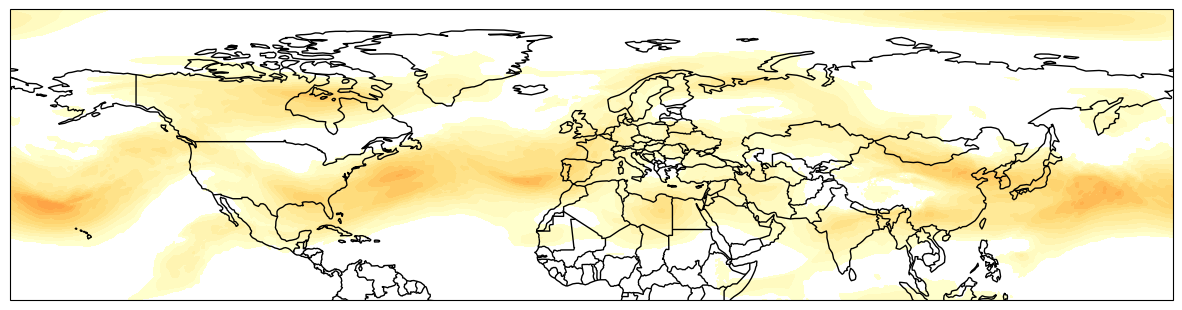

In [45]:
# plot the magnitude of the wind speed at both pressure levels in ds_u and ds_v
fig, ax = plt.subplots(figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add continental outlines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

# Calculate 50th percentile for each pressure level
p50_level0 = ds_u.u.isel(valid_time=0, pressure_level=0).quantile(0.5)
p50_level1 = ds_u.u.isel(valid_time=0, pressure_level=1).quantile(0.5)

# Plot first pressure level in red, only showing values above 50th percentile
level0_data = ds_u.u.isel(valid_time=0, pressure_level=0).where(
    ds_u.u.isel(valid_time=0, pressure_level=0) > p50_level0
)
level0_data.plot.contourf(
    levels=np.linspace(float(p50_level0), 100, 27),
    cmap="YlOrRd",  # Changed to YlOrRd for darker reds
    extend="max", 
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    add_labels=False,
    alpha=1,
    ax=ax
)

# Plot second pressure level in blue, only showing values above 50th percentile
level1_data = ds_u.u.isel(valid_time=0, pressure_level=1).where(
    ds_u.u.isel(valid_time=0, pressure_level=1) > p50_level1
)
# level1_data.plot.contourf(
#     levels=np.linspace(float(p50_level1), 100, 7),
#     cmap="YlGnBu",  # Changed to YlGnBu for darker blues
#     extend="max",
#     transform=ccrs.PlateCarree(), 
#     add_colorbar=False,
#     add_labels=False,
#     alpha=0.7,  # Slightly increased alpha for more visibility
#     ax=ax
# )

plt.savefig('wind_speed_levels.png', dpi=150, bbox_inches='tight')
